# drlnd Project 3: Collaboration and Competition - Tennis

---

https://github.com/sliao-mi-luku/DeepRL-multiple-agents-tennis-udacity-drlnd-p3

Reinforcement learning environment by Unity ML-Agents

This corresponds to **Project #3** of Udacity's Deep Reinforcement Learning Nanodegree (drlnd)

https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893

The multi-agent deep deterministic policy gradient (MADDPG) method is implemented in this project

**Reference**: this code was inspired by:

1. Udacity's GitHub repository **ddpg-pendulum**

   https://github.com/udacity/deep-reinforcement-learning/tree/master/ddpg-pendulum


2. Udacity's drlnd project workspace (jupyter notebook) of **Project: Collaboration and Competition**


3. Udacity's drlnd MADDPG-Lab


## Box 1: Starting the environment

Run the box below to import necessary packages.

In the command env = UnityEnvironment(file_name = '...') paste the path to **Tennis.exe**

For example: `env = UnityEnvironment(file_name = './Tennis_Windows_x86_64/Tennis.exe')`

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from collections import deque
from unityagents import UnityEnvironment
from maddpgAgent_modified import MADDPG_Agent
from buffer_modified import ExperienceMemory
from noiseModels_modified import OrnsteinUhlenbeckNoise, plot_OU

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("\nDevice: {}".format(device))


"""
paste the path to Tennis.exe below
"""
# env = UnityEnvironment(file_name = "/the/path/to/Tennis.exe")
env = UnityEnvironment(file_name = "./Tennis_Windows_x86_64/Tennis.exe")
print("Brain Names:", env.brain_names)  # Add this line


"""
Environments contain brains which are responsible for deciding the actions of their associated agents
"""
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]


"""
The codes below were provided by Udacity, which will display some information of the environment
"""
# reset the environment
env_info = env.reset(train_mode=False)

# number of agents 
num_agents = len(env_info[brain_name].agents)  
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info[brain_name].vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])


print("\nBox 1 done!")


Device: cpu


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Brain Names: ['TennisBrain']
Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]

Box 1 done!


In [2]:
import torch
print (torch. __version__)

0.4.0


## Box 2 - Hyperparameters

Run this box to set the parameters

In [3]:
EPISODES = 10000                   # maximum number of episodes to train

PRINT_EVERY = 1                 # print a new line of information every 200 episodes


## hyperparameters
select_actionor_hidden_sizes = [128, 64]   # input and output sizes of the select_actionor's hidden FC layer
critic_hidden_sizes = [128, 64]  # input and output sizes of the critic's hidden FC layer
gamma = 0.999                      # discounting
select_actionor_lr = 5e-5                  # optimizeing rate of the select_actionor network
critic_lr = 2e-3                  # optimizeing rate of the critic network
critic_L2_decay = 0               # L2 weight decay of the critic network
tau = 0.001                      # the fselect_actionor used for soft-updating select_actionor/critic target networks


## parameters of the noise (Ornstein–Uhlenbeck) process
ou_scale = 1.0                    # initial scaling fselect_actionor
ou_decay = 0.9995                 # decay of the scaling fselect_actionor ou_scale
ou_mu = 0.0                       # asymptotic mean of the noise
ou_theta = 0.15                   # magnitude of the drift term
ou_sigma = 0.20                   # magnitude of the diffusion term


## parameters of the replay buffer
buffer_size = int(1e5)            # size of the buffer
batch_size = 2                  # size of the sampling batch

select_actionor_lr_decay_rate = 0.999     
critic_lr_decay_rate = 0.999

## Dictionary to pass into the MADDPG_Agent to create the agent
config = {}
config['select_actionor_input_size'] = 24                         # dimension of the state (for each agent)
config['select_actionor_output_size'] = 2                         # dimension of the action (for each agent)
config['select_actionor_hidden_sizes'] = select_actionor_hidden_sizes
config['critic_state_size'] = 48                        # dimension of the state (for both agents)
config['critic_select_action_size'] = 4
config['critic_hidden_sizes'] = critic_hidden_sizes
config['select_actionor_lr'] = select_actionor_lr
config['critic_lr'] = critic_lr
config['critic_L2_decay'] = critic_L2_decay
config['gamma'] = gamma
config['tau'] = tau


print("\n Box 2 done!")


 Box 2 done!


## Box 3 - Multi-Agent Deep Deterministic Policy Gradient (MADDPG)

Run this box to train the agent

Simulation of the noise Process:


Episode 1	Score: 0.00	Avg: 0.00\t|ou|: 0.245	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 2	Score: 0.00	Avg: 0.00\t|ou|: 0.328	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 3	Score: 0.00	Avg: 0.00\t|ou|: 0.392	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 4	Score: 0.00	Avg: 0.00\t|ou|: 0.274	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 5	Score: 0.00	Avg: 0.00\t|ou|: 0.413	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 6	Score: 0.00	Avg: 0.00\t|ou|: 0.178	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 7	Score: 0.09	Avg: 0.01\t|ou|: 0.195	Agent 0 Total: 0.00000	Agent 1 Total: 0.09000
Episode 8	Score: 0.00	Avg: 0.01\t|ou|: 0.178	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 9	Score: 0.00	Avg: 0.01\t|ou|: 0.223	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 10	Score: 0.00	Avg: 0.01\t|ou|: 0.402	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 11	Score: 0.00	Avg: 0.01\t|ou|: 0.419

Episode 89	Score: 0.00	Avg: 0.00\t|ou|: 0.451	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 90	Score: 0.00	Avg: 0.00\t|ou|: 0.348	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 91	Score: 0.00	Avg: 0.00\t|ou|: 0.453	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 92	Score: 0.00	Avg: 0.00\t|ou|: 0.247	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 93	Score: 0.10	Avg: 0.00\t|ou|: 0.362	Agent 0 Total: 0.10000	Agent 1 Total: -0.01000
Episode 94	Score: 0.00	Avg: 0.00\t|ou|: 0.357	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 95	Score: 0.00	Avg: 0.00\t|ou|: 0.294	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 96	Score: 0.00	Avg: 0.00\t|ou|: 0.328	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 97	Score: 0.00	Avg: 0.00\t|ou|: 0.275	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 98	Score: 0.00	Avg: 0.00\t|ou|: 0.270	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 99	Score: 0.00	Avg: 0.00\t|ou|: 0.327	Agent 0 Total: 0.00000	A

Episode 177	Score: 0.00	Avg: 0.01\t|ou|: 0.134	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 178	Score: 0.00	Avg: 0.01\t|ou|: 0.386	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 179	Score: 0.00	Avg: 0.01\t|ou|: 0.267	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 180	Score: 0.00	Avg: 0.01\t|ou|: 0.276	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 181	Score: 0.00	Avg: 0.01\t|ou|: 0.244	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 182	Score: 0.00	Avg: 0.01\t|ou|: 0.293	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 183	Score: 0.10	Avg: 0.01\t|ou|: 0.201	Agent 0 Total: -0.01000	Agent 1 Total: 0.10000
Episode 184	Score: 0.00	Avg: 0.01\t|ou|: 0.290	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 185	Score: 0.00	Avg: 0.01\t|ou|: 0.258	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 186	Score: 0.00	Avg: 0.01\t|ou|: 0.279	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 187	Score: 0.00	Avg: 0.01\t|ou|: 0.303	Agent 0 Total

Episode 265	Score: 0.00	Avg: 0.01\t|ou|: 0.262	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 266	Score: 0.00	Avg: 0.01\t|ou|: 0.329	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 267	Score: 0.00	Avg: 0.01\t|ou|: 0.196	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 268	Score: 0.00	Avg: 0.01\t|ou|: 0.253	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 269	Score: 0.00	Avg: 0.01\t|ou|: 0.217	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 270	Score: 0.00	Avg: 0.01\t|ou|: 0.179	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 271	Score: 0.00	Avg: 0.01\t|ou|: 0.444	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 272	Score: 0.00	Avg: 0.01\t|ou|: 0.557	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 273	Score: 0.00	Avg: 0.01\t|ou|: 0.194	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 274	Score: 0.00	Avg: 0.01\t|ou|: 0.224	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 275	Score: 0.00	Avg: 0.01\t|ou|: 0.174	Agent 0 Total

Episode 353	Score: 0.00	Avg: 0.01\t|ou|: 0.166	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 354	Score: 0.00	Avg: 0.01\t|ou|: 0.245	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 355	Score: 0.00	Avg: 0.01\t|ou|: 0.229	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 356	Score: 0.10	Avg: 0.01\t|ou|: 0.317	Agent 0 Total: 0.10000	Agent 1 Total: -0.01000
Episode 357	Score: 0.10	Avg: 0.01\t|ou|: 0.358	Agent 0 Total: -0.01000	Agent 1 Total: 0.10000
Episode 358	Score: 0.00	Avg: 0.01\t|ou|: 0.168	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 359	Score: 0.00	Avg: 0.01\t|ou|: 0.288	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 360	Score: 0.00	Avg: 0.01\t|ou|: 0.367	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 361	Score: 0.00	Avg: 0.01\t|ou|: 0.172	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 362	Score: 0.00	Avg: 0.01\t|ou|: 0.074	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 363	Score: 0.00	Avg: 0.01\t|ou|: 0.310	Agent 0 Total

Episode 441	Score: 0.10	Avg: 0.01\t|ou|: 0.175	Agent 0 Total: 0.10000	Agent 1 Total: -0.01000
Episode 442	Score: 0.00	Avg: 0.01\t|ou|: 0.153	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 443	Score: 0.10	Avg: 0.01\t|ou|: 0.142	Agent 0 Total: -0.01000	Agent 1 Total: 0.10000
Episode 444	Score: 0.00	Avg: 0.01\t|ou|: 0.193	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 445	Score: 0.00	Avg: 0.01\t|ou|: 0.176	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 446	Score: 0.00	Avg: 0.01\t|ou|: 0.356	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 447	Score: 0.00	Avg: 0.01\t|ou|: 0.356	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 448	Score: 0.00	Avg: 0.01\t|ou|: 0.117	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 449	Score: 0.00	Avg: 0.01\t|ou|: 0.226	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 450	Score: 0.00	Avg: 0.01\t|ou|: 0.270	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 451	Score: 0.00	Avg: 0.01\t|ou|: 0.235	Agent 0 Total

Episode 529	Score: 0.10	Avg: 0.01\t|ou|: 0.101	Agent 0 Total: 0.10000	Agent 1 Total: -0.01000
Episode 530	Score: 0.00	Avg: 0.01\t|ou|: 0.217	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 531	Score: 0.00	Avg: 0.01\t|ou|: 0.256	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 532	Score: 0.00	Avg: 0.01\t|ou|: 0.085	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 533	Score: 0.00	Avg: 0.01\t|ou|: 0.259	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 534	Score: 0.00	Avg: 0.01\t|ou|: 0.248	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 535	Score: 0.00	Avg: 0.01\t|ou|: 0.087	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 536	Score: 0.00	Avg: 0.01\t|ou|: 0.184	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 537	Score: 0.00	Avg: 0.01\t|ou|: 0.244	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 538	Score: 0.00	Avg: 0.01\t|ou|: 0.114	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 539	Score: 0.00	Avg: 0.01\t|ou|: 0.224	Agent 0 Total

Episode 617	Score: 0.00	Avg: 0.01\t|ou|: 0.228	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 618	Score: 0.00	Avg: 0.01\t|ou|: 0.287	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 619	Score: 0.00	Avg: 0.01\t|ou|: 0.248	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 620	Score: 0.00	Avg: 0.01\t|ou|: 0.146	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 621	Score: 0.00	Avg: 0.01\t|ou|: 0.173	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 622	Score: 0.00	Avg: 0.01\t|ou|: 0.224	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 623	Score: 0.00	Avg: 0.01\t|ou|: 0.116	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 624	Score: 0.00	Avg: 0.00\t|ou|: 0.337	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 625	Score: 0.10	Avg: 0.01\t|ou|: 0.118	Agent 0 Total: 0.10000	Agent 1 Total: -0.01000
Episode 626	Score: 0.00	Avg: 0.01\t|ou|: 0.143	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 627	Score: 0.00	Avg: 0.01\t|ou|: 0.131	Agent 0 Total

Episode 705	Score: 0.00	Avg: 0.00\t|ou|: 0.200	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 706	Score: 0.10	Avg: 0.00\t|ou|: 0.184	Agent 0 Total: 0.10000	Agent 1 Total: -0.01000
Episode 707	Score: 0.00	Avg: 0.00\t|ou|: 0.149	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 708	Score: 0.00	Avg: 0.00\t|ou|: 0.141	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 709	Score: 0.00	Avg: 0.00\t|ou|: 0.154	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 710	Score: 0.00	Avg: 0.00\t|ou|: 0.286	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 711	Score: 0.09	Avg: 0.01\t|ou|: 0.205	Agent 0 Total: 0.00000	Agent 1 Total: 0.09000
Episode 712	Score: 0.00	Avg: 0.01\t|ou|: 0.234	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 713	Score: 0.00	Avg: 0.01\t|ou|: 0.213	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 714	Score: 0.00	Avg: 0.01\t|ou|: 0.231	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 715	Score: 0.00	Avg: 0.01\t|ou|: 0.149	Agent 0 Total:

Episode 793	Score: 0.00	Avg: 0.01\t|ou|: 0.238	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 794	Score: 0.00	Avg: 0.01\t|ou|: 0.154	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 795	Score: 0.00	Avg: 0.01\t|ou|: 0.153	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 796	Score: 0.00	Avg: 0.01\t|ou|: 0.242	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 797	Score: 0.00	Avg: 0.01\t|ou|: 0.114	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 798	Score: 0.00	Avg: 0.01\t|ou|: 0.231	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 799	Score: 0.00	Avg: 0.01\t|ou|: 0.171	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 800	Score: 0.00	Avg: 0.01\t|ou|: 0.145	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 801	Score: 0.00	Avg: 0.01\t|ou|: 0.317	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 802	Score: 0.00	Avg: 0.01\t|ou|: 0.245	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 803	Score: 0.00	Avg: 0.01\t|ou|: 0.230	Agent 0 Total

Episode 881	Score: 0.00	Avg: 0.00\t|ou|: 0.104	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 882	Score: 0.10	Avg: 0.00\t|ou|: 0.229	Agent 0 Total: 0.09000	Agent 1 Total: 0.10000
Episode 883	Score: 0.00	Avg: 0.00\t|ou|: 0.091	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 884	Score: 0.00	Avg: 0.00\t|ou|: 0.105	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 885	Score: 0.00	Avg: 0.00\t|ou|: 0.133	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 886	Score: 0.00	Avg: 0.00\t|ou|: 0.076	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 887	Score: 0.00	Avg: 0.00\t|ou|: 0.323	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 888	Score: 0.00	Avg: 0.00\t|ou|: 0.173	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 889	Score: 0.00	Avg: 0.00\t|ou|: 0.194	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 890	Score: 0.00	Avg: 0.00\t|ou|: 0.204	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 891	Score: 0.00	Avg: 0.00\t|ou|: 0.227	Agent 0 Total:

Episode 969	Score: 0.00	Avg: 0.00\t|ou|: 0.233	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 970	Score: 0.00	Avg: 0.00\t|ou|: 0.165	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 971	Score: 0.00	Avg: 0.00\t|ou|: 0.135	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 972	Score: 0.00	Avg: 0.00\t|ou|: 0.254	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 973	Score: 0.00	Avg: 0.00\t|ou|: 0.139	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 974	Score: 0.00	Avg: 0.00\t|ou|: 0.125	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 975	Score: 0.00	Avg: 0.00\t|ou|: 0.134	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 976	Score: 0.00	Avg: 0.00\t|ou|: 0.123	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 977	Score: 0.00	Avg: 0.00\t|ou|: 0.068	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 978	Score: 0.00	Avg: 0.00\t|ou|: 0.387	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 979	Score: 0.10	Avg: 0.00\t|ou|: 0.182	Agent 0 Total

Episode 1056	Score: 0.00	Avg: 0.01\t|ou|: 0.140	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 1057	Score: 0.00	Avg: 0.01\t|ou|: 0.131	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 1058	Score: 0.00	Avg: 0.01\t|ou|: 0.195	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 1059	Score: 0.00	Avg: 0.01\t|ou|: 0.152	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 1060	Score: 0.00	Avg: 0.01\t|ou|: 0.169	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 1061	Score: 0.00	Avg: 0.01\t|ou|: 0.161	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 1062	Score: 0.10	Avg: 0.01\t|ou|: 0.143	Agent 0 Total: 0.09000	Agent 1 Total: 0.10000
Episode 1063	Score: 0.00	Avg: 0.01\t|ou|: 0.203	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 1064	Score: 0.00	Avg: 0.01\t|ou|: 0.153	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 1065	Score: 0.00	Avg: 0.01\t|ou|: 0.096	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 1066	Score: 0.00	Avg: 0.01\t|ou|: 0.145	Age

Episode 1143	Score: 0.00	Avg: 0.01\t|ou|: 0.183	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 1144	Score: 0.00	Avg: 0.01\t|ou|: 0.142	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 1145	Score: 0.00	Avg: 0.01\t|ou|: 0.165	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 1146	Score: 0.00	Avg: 0.01\t|ou|: 0.324	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 1147	Score: 0.00	Avg: 0.01\t|ou|: 0.243	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 1148	Score: 0.00	Avg: 0.01\t|ou|: 0.174	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 1149	Score: 0.00	Avg: 0.01\t|ou|: 0.146	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 1150	Score: 0.00	Avg: 0.01\t|ou|: 0.242	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 1151	Score: 0.00	Avg: 0.01\t|ou|: 0.137	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 1152	Score: 0.00	Avg: 0.01\t|ou|: 0.222	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 1153	Score: 0.00	Avg: 0.01\t|ou|: 0.238	Ag

Episode 1230	Score: 0.10	Avg: 0.00\t|ou|: 0.252	Agent 0 Total: 0.10000	Agent 1 Total: -0.01000
Episode 1231	Score: 0.00	Avg: 0.00\t|ou|: 0.312	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 1232	Score: 0.00	Avg: 0.00\t|ou|: 0.295	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 1233	Score: 0.00	Avg: 0.00\t|ou|: 0.209	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 1234	Score: 0.00	Avg: 0.00\t|ou|: 0.148	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 1235	Score: 0.00	Avg: 0.00\t|ou|: 0.095	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 1236	Score: 0.00	Avg: 0.00\t|ou|: 0.172	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 1237	Score: 0.09	Avg: 0.01\t|ou|: 0.156	Agent 0 Total: 0.00000	Agent 1 Total: 0.09000
Episode 1238	Score: 0.10	Avg: 0.01\t|ou|: 0.171	Agent 0 Total: 0.10000	Agent 1 Total: -0.01000
Episode 1239	Score: 0.00	Avg: 0.01\t|ou|: 0.251	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 1240	Score: 0.00	Avg: 0.01\t|ou|: 0.202	Age

Episode 1317	Score: 0.10	Avg: 0.01\t|ou|: 0.066	Agent 0 Total: -0.01000	Agent 1 Total: 0.10000
Episode 1318	Score: 0.00	Avg: 0.01\t|ou|: 0.220	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 1319	Score: 0.10	Avg: 0.01\t|ou|: 0.160	Agent 0 Total: 0.10000	Agent 1 Total: -0.01000
Episode 1320	Score: 0.00	Avg: 0.01\t|ou|: 0.085	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 1321	Score: 0.00	Avg: 0.01\t|ou|: 0.147	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 1322	Score: 0.00	Avg: 0.01\t|ou|: 0.173	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 1323	Score: 0.00	Avg: 0.01\t|ou|: 0.216	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 1324	Score: 0.00	Avg: 0.01\t|ou|: 0.133	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 1325	Score: 0.00	Avg: 0.01\t|ou|: 0.115	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 1326	Score: 0.00	Avg: 0.01\t|ou|: 0.128	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 1327	Score: 0.00	Avg: 0.01\t|ou|: 0.139	Ag

Episode 1404	Score: 0.00	Avg: 0.01\t|ou|: 0.151	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 1405	Score: 0.00	Avg: 0.01\t|ou|: 0.175	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 1406	Score: 0.00	Avg: 0.01\t|ou|: 0.148	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 1407	Score: 0.00	Avg: 0.01\t|ou|: 0.183	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 1408	Score: 0.00	Avg: 0.01\t|ou|: 0.219	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 1409	Score: 0.00	Avg: 0.01\t|ou|: 0.281	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 1410	Score: 0.00	Avg: 0.01\t|ou|: 0.154	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 1411	Score: 0.00	Avg: 0.01\t|ou|: 0.181	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 1412	Score: 0.00	Avg: 0.01\t|ou|: 0.112	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 1413	Score: 0.00	Avg: 0.01\t|ou|: 0.081	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 1414	Score: 0.00	Avg: 0.00\t|ou|: 0.170	Ag

Episode 1491	Score: 0.00	Avg: 0.01\t|ou|: 0.212	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 1492	Score: 0.00	Avg: 0.01\t|ou|: 0.137	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 1493	Score: 0.00	Avg: 0.01\t|ou|: 0.076	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 1494	Score: 0.00	Avg: 0.01\t|ou|: 0.182	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 1495	Score: 0.00	Avg: 0.01\t|ou|: 0.153	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 1496	Score: 0.00	Avg: 0.01\t|ou|: 0.206	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 1497	Score: 0.00	Avg: 0.01\t|ou|: 0.207	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 1498	Score: 0.00	Avg: 0.01\t|ou|: 0.142	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 1499	Score: 0.00	Avg: 0.01\t|ou|: 0.082	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 1500	Score: 0.00	Avg: 0.01\t|ou|: 0.164	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 1501	Score: 0.00	Avg: 0.01\t|ou|: 0.179	Ag

Episode 1578	Score: 0.00	Avg: 0.00\t|ou|: 0.135	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 1579	Score: 0.00	Avg: 0.00\t|ou|: 0.180	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 1580	Score: 0.00	Avg: 0.00\t|ou|: 0.055	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 1581	Score: 0.00	Avg: 0.00\t|ou|: 0.137	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 1582	Score: 0.00	Avg: 0.00\t|ou|: 0.192	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 1583	Score: 0.00	Avg: 0.00\t|ou|: 0.070	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 1584	Score: 0.00	Avg: 0.00\t|ou|: 0.111	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 1585	Score: 0.00	Avg: 0.00\t|ou|: 0.193	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 1586	Score: 0.00	Avg: 0.00\t|ou|: 0.171	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 1587	Score: 0.00	Avg: 0.00\t|ou|: 0.192	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 1588	Score: 0.00	Avg: 0.00\t|ou|: 0.093	Ag

Episode 1665	Score: 0.00	Avg: 0.01\t|ou|: 0.165	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 1666	Score: 0.00	Avg: 0.01\t|ou|: 0.082	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 1667	Score: 0.00	Avg: 0.01\t|ou|: 0.159	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 1668	Score: 0.00	Avg: 0.01\t|ou|: 0.153	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 1669	Score: 0.00	Avg: 0.01\t|ou|: 0.089	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 1670	Score: 0.00	Avg: 0.01\t|ou|: 0.097	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 1671	Score: 0.00	Avg: 0.01\t|ou|: 0.184	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 1672	Score: 0.10	Avg: 0.01\t|ou|: 0.091	Agent 0 Total: 0.10000	Agent 1 Total: -0.01000
Episode 1673	Score: 0.00	Avg: 0.01\t|ou|: 0.110	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 1674	Score: 0.00	Avg: 0.01\t|ou|: 0.073	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 1675	Score: 0.00	Avg: 0.01\t|ou|: 0.116	Ag

Episode 1752	Score: 0.09	Avg: 0.01\t|ou|: 0.104	Agent 0 Total: 0.00000	Agent 1 Total: 0.09000
Episode 1753	Score: 0.00	Avg: 0.01\t|ou|: 0.094	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 1754	Score: 0.00	Avg: 0.00\t|ou|: 0.128	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 1755	Score: 0.00	Avg: 0.00\t|ou|: 0.120	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 1756	Score: 0.00	Avg: 0.00\t|ou|: 0.145	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 1757	Score: 0.00	Avg: 0.00\t|ou|: 0.088	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 1758	Score: 0.00	Avg: 0.00\t|ou|: 0.183	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 1759	Score: 0.00	Avg: 0.00\t|ou|: 0.181	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 1760	Score: 0.00	Avg: 0.00\t|ou|: 0.097	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 1761	Score: 0.00	Avg: 0.00\t|ou|: 0.096	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 1762	Score: 0.00	Avg: 0.00\t|ou|: 0.067	Age

Episode 1839	Score: 0.00	Avg: 0.01\t|ou|: 0.057	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 1840	Score: 0.00	Avg: 0.01\t|ou|: 0.072	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 1841	Score: 0.00	Avg: 0.01\t|ou|: 0.155	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 1842	Score: 0.00	Avg: 0.01\t|ou|: 0.078	Agent 0 Total: 0.00000	Agent 1 Total: -0.02000
Episode 1843	Score: 0.00	Avg: 0.01\t|ou|: 0.103	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 1844	Score: 0.00	Avg: 0.01\t|ou|: 0.147	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 1845	Score: 0.00	Avg: 0.01\t|ou|: 0.137	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 1846	Score: 0.00	Avg: 0.01\t|ou|: 0.146	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 1847	Score: 0.00	Avg: 0.01\t|ou|: 0.150	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 1848	Score: 0.00	Avg: 0.01\t|ou|: 0.117	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 1849	Score: 0.00	Avg: 0.01\t|ou|: 0.203	Ag

Episode 1926	Score: 0.00	Avg: 0.01\t|ou|: 0.223	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 1927	Score: 0.10	Avg: 0.01\t|ou|: 0.095	Agent 0 Total: 0.10000	Agent 1 Total: -0.01000
Episode 1928	Score: 0.00	Avg: 0.01\t|ou|: 0.076	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 1929	Score: 0.00	Avg: 0.01\t|ou|: 0.063	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 1930	Score: 0.10	Avg: 0.01\t|ou|: 0.199	Agent 0 Total: 0.10000	Agent 1 Total: -0.01000
Episode 1931	Score: 0.00	Avg: 0.01\t|ou|: 0.149	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 1932	Score: 0.00	Avg: 0.01\t|ou|: 0.163	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 1933	Score: 0.00	Avg: 0.01\t|ou|: 0.083	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 1934	Score: 0.00	Avg: 0.01\t|ou|: 0.063	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 1935	Score: 0.00	Avg: 0.01\t|ou|: 0.088	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 1936	Score: 0.00	Avg: 0.01\t|ou|: 0.090	Ag

Episode 2013	Score: 0.00	Avg: 0.01\t|ou|: 0.134	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 2014	Score: 0.00	Avg: 0.01\t|ou|: 0.091	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 2015	Score: 0.00	Avg: 0.01\t|ou|: 0.046	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 2016	Score: 0.00	Avg: 0.01\t|ou|: 0.113	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 2017	Score: 0.00	Avg: 0.01\t|ou|: 0.159	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 2018	Score: 0.00	Avg: 0.01\t|ou|: 0.154	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 2019	Score: 0.00	Avg: 0.01\t|ou|: 0.164	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 2020	Score: 0.00	Avg: 0.01\t|ou|: 0.077	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 2021	Score: 0.00	Avg: 0.01\t|ou|: 0.182	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 2022	Score: 0.00	Avg: 0.01\t|ou|: 0.137	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 2023	Score: 0.00	Avg: 0.01\t|ou|: 0.051	Ag

Episode 2100	Score: 0.00	Avg: 0.01\t|ou|: 0.186	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 2101	Score: 0.00	Avg: 0.01\t|ou|: 0.094	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 2102	Score: 0.00	Avg: 0.01\t|ou|: 0.113	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 2103	Score: 0.00	Avg: 0.01\t|ou|: 0.119	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 2104	Score: 0.00	Avg: 0.01\t|ou|: 0.175	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 2105	Score: 0.00	Avg: 0.01\t|ou|: 0.106	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 2106	Score: 0.00	Avg: 0.01\t|ou|: 0.036	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 2107	Score: 0.00	Avg: 0.01\t|ou|: 0.084	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 2108	Score: 0.00	Avg: 0.01\t|ou|: 0.062	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 2109	Score: 0.00	Avg: 0.01\t|ou|: 0.168	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 2110	Score: 0.00	Avg: 0.01\t|ou|: 0.082	Ag

Episode 2187	Score: 0.00	Avg: 0.00\t|ou|: 0.141	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 2188	Score: 0.00	Avg: 0.00\t|ou|: 0.103	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 2189	Score: 0.10	Avg: 0.00\t|ou|: 0.137	Agent 0 Total: -0.01000	Agent 1 Total: 0.10000
Episode 2190	Score: 0.00	Avg: 0.00\t|ou|: 0.141	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 2191	Score: 0.00	Avg: 0.00\t|ou|: 0.082	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 2192	Score: 0.00	Avg: 0.00\t|ou|: 0.052	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 2193	Score: 0.00	Avg: 0.00\t|ou|: 0.086	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 2194	Score: 0.10	Avg: 0.00\t|ou|: 0.077	Agent 0 Total: -0.01000	Agent 1 Total: 0.10000
Episode 2195	Score: 0.00	Avg: 0.00\t|ou|: 0.054	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 2196	Score: 0.00	Avg: 0.00\t|ou|: 0.140	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 2197	Score: 0.00	Avg: 0.00\t|ou|: 0.129	Ag

Episode 2274	Score: 0.00	Avg: 0.00\t|ou|: 0.134	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 2275	Score: 0.10	Avg: 0.01\t|ou|: 0.098	Agent 0 Total: -0.01000	Agent 1 Total: 0.10000
Episode 2276	Score: 0.00	Avg: 0.01\t|ou|: 0.070	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 2277	Score: 0.00	Avg: 0.01\t|ou|: 0.112	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 2278	Score: 0.00	Avg: 0.01\t|ou|: 0.098	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 2279	Score: 0.00	Avg: 0.01\t|ou|: 0.152	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 2280	Score: 0.00	Avg: 0.01\t|ou|: 0.074	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 2281	Score: 0.00	Avg: 0.01\t|ou|: 0.072	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 2282	Score: 0.00	Avg: 0.01\t|ou|: 0.102	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 2283	Score: 0.00	Avg: 0.01\t|ou|: 0.197	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 2284	Score: 0.00	Avg: 0.01\t|ou|: 0.127	Ag

Episode 2361	Score: 0.00	Avg: 0.01\t|ou|: 0.041	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 2362	Score: 0.00	Avg: 0.01\t|ou|: 0.086	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 2363	Score: 0.00	Avg: 0.01\t|ou|: 0.074	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 2364	Score: 0.00	Avg: 0.01\t|ou|: 0.075	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 2365	Score: 0.00	Avg: 0.01\t|ou|: 0.066	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 2366	Score: 0.00	Avg: 0.01\t|ou|: 0.127	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 2367	Score: 0.00	Avg: 0.01\t|ou|: 0.103	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 2368	Score: 0.00	Avg: 0.01\t|ou|: 0.106	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 2369	Score: 0.00	Avg: 0.01\t|ou|: 0.072	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 2370	Score: 0.00	Avg: 0.01\t|ou|: 0.123	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 2371	Score: 0.00	Avg: 0.01\t|ou|: 0.138	Ag

Episode 2448	Score: 0.00	Avg: 0.00\t|ou|: 0.110	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 2449	Score: 0.00	Avg: 0.00\t|ou|: 0.126	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 2450	Score: 0.00	Avg: 0.00\t|ou|: 0.063	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 2451	Score: 0.00	Avg: 0.00\t|ou|: 0.113	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 2452	Score: 0.00	Avg: 0.00\t|ou|: 0.161	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 2453	Score: 0.00	Avg: 0.00\t|ou|: 0.059	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 2454	Score: 0.00	Avg: 0.00\t|ou|: 0.081	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 2455	Score: 0.10	Avg: 0.00\t|ou|: 0.073	Agent 0 Total: -0.01000	Agent 1 Total: 0.10000
Episode 2456	Score: 0.00	Avg: 0.00\t|ou|: 0.034	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 2457	Score: 0.00	Avg: 0.00\t|ou|: 0.093	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 2458	Score: 0.00	Avg: 0.00\t|ou|: 0.081	Ag

Episode 2535	Score: 0.00	Avg: 0.00\t|ou|: 0.072	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 2536	Score: 0.00	Avg: 0.00\t|ou|: 0.122	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 2537	Score: 0.00	Avg: 0.00\t|ou|: 0.151	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 2538	Score: 0.10	Avg: 0.01\t|ou|: 0.169	Agent 0 Total: 0.10000	Agent 1 Total: -0.01000
Episode 2539	Score: 0.00	Avg: 0.01\t|ou|: 0.069	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 2540	Score: 0.00	Avg: 0.01\t|ou|: 0.078	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 2541	Score: 0.00	Avg: 0.01\t|ou|: 0.064	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 2542	Score: 0.00	Avg: 0.01\t|ou|: 0.089	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 2543	Score: 0.00	Avg: 0.01\t|ou|: 0.045	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 2544	Score: 0.10	Avg: 0.01\t|ou|: 0.055	Agent 0 Total: -0.01000	Agent 1 Total: 0.10000
Episode 2545	Score: 0.00	Avg: 0.01\t|ou|: 0.068	Ag

Episode 2622	Score: 0.00	Avg: 0.01\t|ou|: 0.047	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 2623	Score: 0.00	Avg: 0.01\t|ou|: 0.088	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 2624	Score: 0.00	Avg: 0.01\t|ou|: 0.062	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 2625	Score: 0.00	Avg: 0.01\t|ou|: 0.096	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 2626	Score: 0.00	Avg: 0.01\t|ou|: 0.120	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 2627	Score: 0.00	Avg: 0.01\t|ou|: 0.054	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 2628	Score: 0.00	Avg: 0.01\t|ou|: 0.123	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 2629	Score: 0.00	Avg: 0.01\t|ou|: 0.055	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 2630	Score: 0.00	Avg: 0.01\t|ou|: 0.081	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 2631	Score: 0.10	Avg: 0.01\t|ou|: 0.134	Agent 0 Total: 0.10000	Agent 1 Total: -0.01000
Episode 2632	Score: 0.00	Avg: 0.01\t|ou|: 0.095	Ag

Episode 2709	Score: 0.00	Avg: 0.00\t|ou|: 0.080	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 2710	Score: 0.00	Avg: 0.00\t|ou|: 0.098	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 2711	Score: 0.00	Avg: 0.00\t|ou|: 0.045	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 2712	Score: 0.00	Avg: 0.00\t|ou|: 0.079	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 2713	Score: 0.00	Avg: 0.00\t|ou|: 0.079	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 2714	Score: 0.10	Avg: 0.00\t|ou|: 0.076	Agent 0 Total: 0.10000	Agent 1 Total: -0.01000
Episode 2715	Score: 0.00	Avg: 0.00\t|ou|: 0.137	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 2716	Score: 0.00	Avg: 0.00\t|ou|: 0.089	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 2717	Score: 0.00	Avg: 0.00\t|ou|: 0.070	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 2718	Score: 0.00	Avg: 0.00\t|ou|: 0.063	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 2719	Score: 0.10	Avg: 0.00\t|ou|: 0.037	Ag

Episode 2796	Score: 0.00	Avg: 0.00\t|ou|: 0.073	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 2797	Score: 0.00	Avg: 0.00\t|ou|: 0.134	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 2798	Score: 0.00	Avg: 0.00\t|ou|: 0.049	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 2799	Score: 0.00	Avg: 0.00\t|ou|: 0.103	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 2800	Score: 0.00	Avg: 0.00\t|ou|: 0.098	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 2801	Score: 0.00	Avg: 0.00\t|ou|: 0.146	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 2802	Score: 0.00	Avg: 0.00\t|ou|: 0.100	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 2803	Score: 0.10	Avg: 0.01\t|ou|: 0.083	Agent 0 Total: 0.10000	Agent 1 Total: 0.09000
Episode 2804	Score: 0.00	Avg: 0.01\t|ou|: 0.062	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 2805	Score: 0.00	Avg: 0.01\t|ou|: 0.100	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 2806	Score: 0.00	Avg: 0.01\t|ou|: 0.100	Age

Episode 2883	Score: 0.00	Avg: 0.00\t|ou|: 0.042	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 2884	Score: 0.00	Avg: 0.00\t|ou|: 0.071	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 2885	Score: 0.00	Avg: 0.00\t|ou|: 0.089	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 2886	Score: 0.10	Avg: 0.01\t|ou|: 0.096	Agent 0 Total: 0.10000	Agent 1 Total: -0.01000
Episode 2887	Score: 0.00	Avg: 0.01\t|ou|: 0.064	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 2888	Score: 0.00	Avg: 0.01\t|ou|: 0.135	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 2889	Score: 0.00	Avg: 0.01\t|ou|: 0.041	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 2890	Score: 0.00	Avg: 0.01\t|ou|: 0.084	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 2891	Score: 0.00	Avg: 0.01\t|ou|: 0.054	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 2892	Score: 0.00	Avg: 0.01\t|ou|: 0.071	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 2893	Score: 0.00	Avg: 0.00\t|ou|: 0.110	Ag

Episode 2970	Score: 0.00	Avg: 0.01\t|ou|: 0.062	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 2971	Score: 0.00	Avg: 0.01\t|ou|: 0.060	Agent 0 Total: 0.00000	Agent 1 Total: -0.02000
Episode 2972	Score: 0.00	Avg: 0.01\t|ou|: 0.076	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 2973	Score: 0.00	Avg: 0.01\t|ou|: 0.089	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 2974	Score: 0.00	Avg: 0.01\t|ou|: 0.019	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 2975	Score: 0.00	Avg: 0.01\t|ou|: 0.126	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 2976	Score: 0.00	Avg: 0.01\t|ou|: 0.106	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 2977	Score: 0.00	Avg: 0.01\t|ou|: 0.092	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 2978	Score: 0.00	Avg: 0.01\t|ou|: 0.085	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 2979	Score: 0.00	Avg: 0.01\t|ou|: 0.080	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 2980	Score: 0.00	Avg: 0.01\t|ou|: 0.086	Ag

Episode 3057	Score: 0.00	Avg: 0.00\t|ou|: 0.065	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 3058	Score: 0.00	Avg: 0.00\t|ou|: 0.085	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 3059	Score: 0.00	Avg: 0.00\t|ou|: 0.035	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 3060	Score: 0.00	Avg: 0.00\t|ou|: 0.052	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 3061	Score: 0.00	Avg: 0.00\t|ou|: 0.096	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 3062	Score: 0.00	Avg: 0.00\t|ou|: 0.082	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 3063	Score: 0.00	Avg: 0.00\t|ou|: 0.037	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 3064	Score: 0.00	Avg: 0.00\t|ou|: 0.063	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 3065	Score: 0.00	Avg: 0.00\t|ou|: 0.053	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 3066	Score: 0.00	Avg: 0.00\t|ou|: 0.073	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 3067	Score: 0.00	Avg: 0.00\t|ou|: 0.058	Ag

Episode 3144	Score: 0.00	Avg: 0.00\t|ou|: 0.118	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 3145	Score: 0.00	Avg: 0.00\t|ou|: 0.076	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 3146	Score: 0.00	Avg: 0.00\t|ou|: 0.064	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 3147	Score: 0.00	Avg: 0.00\t|ou|: 0.074	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 3148	Score: 0.00	Avg: 0.00\t|ou|: 0.022	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 3149	Score: 0.00	Avg: 0.00\t|ou|: 0.063	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 3150	Score: 0.00	Avg: 0.00\t|ou|: 0.057	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 3151	Score: 0.00	Avg: 0.00\t|ou|: 0.037	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 3152	Score: 0.00	Avg: 0.00\t|ou|: 0.064	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 3153	Score: 0.00	Avg: 0.00\t|ou|: 0.081	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 3154	Score: 0.00	Avg: 0.00\t|ou|: 0.069	Ag

Episode 3231	Score: 0.00	Avg: 0.00\t|ou|: 0.036	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 3232	Score: 0.00	Avg: 0.00\t|ou|: 0.026	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 3233	Score: 0.00	Avg: 0.00\t|ou|: 0.064	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 3234	Score: 0.00	Avg: 0.00\t|ou|: 0.095	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 3235	Score: 0.00	Avg: 0.00\t|ou|: 0.061	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 3236	Score: 0.00	Avg: 0.00\t|ou|: 0.069	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 3237	Score: 0.00	Avg: 0.00\t|ou|: 0.033	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 3238	Score: 0.00	Avg: 0.00\t|ou|: 0.030	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 3239	Score: 0.00	Avg: 0.00\t|ou|: 0.025	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 3240	Score: 0.00	Avg: 0.00\t|ou|: 0.117	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 3241	Score: 0.00	Avg: 0.00\t|ou|: 0.075	Ag

Episode 3318	Score: 0.00	Avg: 0.00\t|ou|: 0.091	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 3319	Score: 0.00	Avg: 0.00\t|ou|: 0.030	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 3320	Score: 0.00	Avg: 0.00\t|ou|: 0.025	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 3321	Score: 0.00	Avg: 0.00\t|ou|: 0.040	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 3322	Score: 0.00	Avg: 0.00\t|ou|: 0.050	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 3323	Score: 0.00	Avg: 0.00\t|ou|: 0.057	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 3324	Score: 0.00	Avg: 0.00\t|ou|: 0.065	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 3325	Score: 0.00	Avg: 0.00\t|ou|: 0.052	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 3326	Score: 0.00	Avg: 0.00\t|ou|: 0.086	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 3327	Score: 0.00	Avg: 0.00\t|ou|: 0.026	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 3328	Score: 0.00	Avg: 0.00\t|ou|: 0.085	Ag

Episode 3405	Score: 0.00	Avg: 0.00\t|ou|: 0.044	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 3406	Score: 0.00	Avg: 0.00\t|ou|: 0.036	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 3407	Score: 0.00	Avg: 0.00\t|ou|: 0.049	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 3408	Score: 0.00	Avg: 0.00\t|ou|: 0.082	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 3409	Score: 0.00	Avg: 0.00\t|ou|: 0.063	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 3410	Score: 0.00	Avg: 0.00\t|ou|: 0.078	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 3411	Score: 0.00	Avg: 0.00\t|ou|: 0.065	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 3412	Score: 0.00	Avg: 0.00\t|ou|: 0.051	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 3413	Score: 0.00	Avg: 0.00\t|ou|: 0.092	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 3414	Score: 0.00	Avg: 0.00\t|ou|: 0.042	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 3415	Score: 0.00	Avg: 0.00\t|ou|: 0.085	Ag

Episode 3492	Score: 0.00	Avg: 0.00\t|ou|: 0.059	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 3493	Score: 0.00	Avg: 0.00\t|ou|: 0.023	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 3494	Score: 0.00	Avg: 0.00\t|ou|: 0.081	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 3495	Score: 0.00	Avg: 0.00\t|ou|: 0.053	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 3496	Score: 0.00	Avg: 0.00\t|ou|: 0.035	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 3497	Score: 0.00	Avg: 0.00\t|ou|: 0.040	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 3498	Score: 0.00	Avg: 0.00\t|ou|: 0.056	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 3499	Score: 0.00	Avg: 0.00\t|ou|: 0.083	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 3500	Score: 0.00	Avg: 0.00\t|ou|: 0.016	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 3501	Score: 0.00	Avg: 0.00\t|ou|: 0.057	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 3502	Score: 0.00	Avg: 0.00\t|ou|: 0.058	Ag

Episode 3579	Score: 0.00	Avg: 0.00\t|ou|: 0.019	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 3580	Score: 0.00	Avg: 0.00\t|ou|: 0.035	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 3581	Score: 0.00	Avg: 0.00\t|ou|: 0.046	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 3582	Score: 0.00	Avg: 0.00\t|ou|: 0.045	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 3583	Score: 0.00	Avg: 0.00\t|ou|: 0.028	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 3584	Score: 0.00	Avg: 0.00\t|ou|: 0.080	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 3585	Score: 0.00	Avg: 0.00\t|ou|: 0.098	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 3586	Score: 0.00	Avg: 0.00\t|ou|: 0.056	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 3587	Score: 0.00	Avg: 0.00\t|ou|: 0.060	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 3588	Score: 0.00	Avg: 0.00\t|ou|: 0.037	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 3589	Score: 0.00	Avg: 0.00\t|ou|: 0.065	Ag

Episode 3666	Score: 0.00	Avg: 0.00\t|ou|: 0.052	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 3667	Score: 0.00	Avg: 0.00\t|ou|: 0.014	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 3668	Score: 0.00	Avg: 0.00\t|ou|: 0.061	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 3669	Score: 0.00	Avg: 0.00\t|ou|: 0.064	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 3670	Score: 0.00	Avg: 0.00\t|ou|: 0.071	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 3671	Score: 0.00	Avg: 0.00\t|ou|: 0.037	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 3672	Score: 0.00	Avg: 0.00\t|ou|: 0.032	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 3673	Score: 0.00	Avg: 0.00\t|ou|: 0.064	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 3674	Score: 0.00	Avg: 0.00\t|ou|: 0.058	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 3675	Score: 0.00	Avg: 0.00\t|ou|: 0.044	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 3676	Score: 0.00	Avg: 0.00\t|ou|: 0.029	Ag

Episode 3753	Score: 0.00	Avg: 0.00\t|ou|: 0.062	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 3754	Score: 0.00	Avg: 0.00\t|ou|: 0.045	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 3755	Score: 0.00	Avg: 0.00\t|ou|: 0.035	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 3756	Score: 0.00	Avg: 0.00\t|ou|: 0.036	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 3757	Score: 0.00	Avg: 0.00\t|ou|: 0.027	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 3758	Score: 0.00	Avg: 0.00\t|ou|: 0.076	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 3759	Score: 0.00	Avg: 0.00\t|ou|: 0.036	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 3760	Score: 0.00	Avg: 0.00\t|ou|: 0.029	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 3761	Score: 0.00	Avg: 0.00\t|ou|: 0.044	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 3762	Score: 0.00	Avg: 0.00\t|ou|: 0.055	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 3763	Score: 0.00	Avg: 0.00\t|ou|: 0.031	Ag

Episode 3840	Score: 0.00	Avg: 0.00\t|ou|: 0.049	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 3841	Score: 0.00	Avg: 0.00\t|ou|: 0.036	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 3842	Score: 0.00	Avg: 0.00\t|ou|: 0.040	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 3843	Score: 0.00	Avg: 0.00\t|ou|: 0.039	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 3844	Score: 0.00	Avg: 0.00\t|ou|: 0.059	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 3845	Score: 0.00	Avg: 0.00\t|ou|: 0.059	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 3846	Score: 0.00	Avg: 0.00\t|ou|: 0.031	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 3847	Score: 0.00	Avg: 0.00\t|ou|: 0.037	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 3848	Score: 0.00	Avg: 0.00\t|ou|: 0.033	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 3849	Score: 0.00	Avg: 0.00\t|ou|: 0.049	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 3850	Score: 0.00	Avg: 0.00\t|ou|: 0.057	Ag

Episode 3927	Score: 0.00	Avg: 0.00\t|ou|: 0.032	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 3928	Score: 0.00	Avg: 0.00\t|ou|: 0.055	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 3929	Score: 0.00	Avg: 0.00\t|ou|: 0.049	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 3930	Score: 0.00	Avg: 0.00\t|ou|: 0.078	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 3931	Score: 0.00	Avg: 0.00\t|ou|: 0.094	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 3932	Score: 0.00	Avg: 0.00\t|ou|: 0.020	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 3933	Score: 0.00	Avg: 0.00\t|ou|: 0.021	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 3934	Score: 0.00	Avg: 0.00\t|ou|: 0.077	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 3935	Score: 0.00	Avg: 0.00\t|ou|: 0.057	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 3936	Score: 0.00	Avg: 0.00\t|ou|: 0.072	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 3937	Score: 0.00	Avg: 0.00\t|ou|: 0.031	Ag

Episode 4014	Score: 0.00	Avg: 0.00\t|ou|: 0.037	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 4015	Score: 0.00	Avg: 0.00\t|ou|: 0.053	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 4016	Score: 0.00	Avg: 0.00\t|ou|: 0.051	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 4017	Score: 0.00	Avg: 0.00\t|ou|: 0.042	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 4018	Score: 0.00	Avg: 0.00\t|ou|: 0.020	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 4019	Score: 0.00	Avg: 0.00\t|ou|: 0.052	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 4020	Score: 0.00	Avg: 0.00\t|ou|: 0.032	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 4021	Score: 0.00	Avg: 0.00\t|ou|: 0.040	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 4022	Score: 0.00	Avg: 0.00\t|ou|: 0.029	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 4023	Score: 0.00	Avg: 0.00\t|ou|: 0.031	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 4024	Score: 0.09	Avg: 0.00\t|ou|: 0.047	Ag

Episode 4101	Score: 0.00	Avg: 0.00\t|ou|: 0.033	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 4102	Score: 0.00	Avg: 0.00\t|ou|: 0.060	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 4103	Score: 0.00	Avg: 0.00\t|ou|: 0.067	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 4104	Score: 0.00	Avg: 0.00\t|ou|: 0.032	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 4105	Score: 0.00	Avg: 0.00\t|ou|: 0.018	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 4106	Score: 0.00	Avg: 0.00\t|ou|: 0.047	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 4107	Score: 0.00	Avg: 0.00\t|ou|: 0.028	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 4108	Score: 0.00	Avg: 0.00\t|ou|: 0.059	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 4109	Score: 0.00	Avg: 0.00\t|ou|: 0.041	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 4110	Score: 0.00	Avg: 0.00\t|ou|: 0.032	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 4111	Score: 0.00	Avg: 0.00\t|ou|: 0.002	Ag

Episode 4188	Score: 0.00	Avg: 0.00\t|ou|: 0.023	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 4189	Score: 0.00	Avg: 0.00\t|ou|: 0.048	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 4190	Score: 0.00	Avg: 0.00\t|ou|: 0.023	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 4191	Score: 0.00	Avg: 0.00\t|ou|: 0.045	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 4192	Score: 0.00	Avg: 0.00\t|ou|: 0.013	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 4193	Score: 0.00	Avg: 0.00\t|ou|: 0.027	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 4194	Score: 0.00	Avg: 0.00\t|ou|: 0.028	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 4195	Score: 0.00	Avg: 0.00\t|ou|: 0.038	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 4196	Score: 0.00	Avg: 0.00\t|ou|: 0.076	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 4197	Score: 0.00	Avg: 0.00\t|ou|: 0.073	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 4198	Score: 0.00	Avg: 0.00\t|ou|: 0.013	Ag

Episode 4275	Score: 0.00	Avg: 0.00\t|ou|: 0.047	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 4276	Score: 0.00	Avg: 0.00\t|ou|: 0.058	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 4277	Score: 0.00	Avg: 0.00\t|ou|: 0.041	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 4278	Score: 0.00	Avg: 0.00\t|ou|: 0.028	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 4279	Score: 0.00	Avg: 0.00\t|ou|: 0.024	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 4280	Score: 0.00	Avg: 0.00\t|ou|: 0.032	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 4281	Score: 0.00	Avg: 0.00\t|ou|: 0.023	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 4282	Score: 0.00	Avg: 0.00\t|ou|: 0.023	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 4283	Score: 0.00	Avg: 0.00\t|ou|: 0.018	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 4284	Score: 0.00	Avg: 0.00\t|ou|: 0.047	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 4285	Score: 0.00	Avg: 0.00\t|ou|: 0.031	Ag

Episode 4362	Score: 0.00	Avg: 0.00\t|ou|: 0.039	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 4363	Score: 0.00	Avg: 0.00\t|ou|: 0.034	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 4364	Score: 0.00	Avg: 0.00\t|ou|: 0.042	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 4365	Score: 0.00	Avg: 0.00\t|ou|: 0.033	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 4366	Score: 0.00	Avg: 0.00\t|ou|: 0.021	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 4367	Score: 0.00	Avg: 0.00\t|ou|: 0.024	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 4368	Score: 0.00	Avg: 0.00\t|ou|: 0.045	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 4369	Score: 0.00	Avg: 0.00\t|ou|: 0.035	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 4370	Score: 0.00	Avg: 0.00\t|ou|: 0.038	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 4371	Score: 0.00	Avg: 0.00\t|ou|: 0.020	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 4372	Score: 0.00	Avg: 0.00\t|ou|: 0.033	Ag

Episode 4449	Score: 0.00	Avg: 0.00\t|ou|: 0.046	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 4450	Score: 0.00	Avg: 0.00\t|ou|: 0.021	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 4451	Score: 0.00	Avg: 0.00\t|ou|: 0.028	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 4452	Score: 0.00	Avg: 0.00\t|ou|: 0.055	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 4453	Score: 0.00	Avg: 0.00\t|ou|: 0.029	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 4454	Score: 0.00	Avg: 0.00\t|ou|: 0.020	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 4455	Score: 0.00	Avg: 0.00\t|ou|: 0.032	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 4456	Score: 0.00	Avg: 0.00\t|ou|: 0.024	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 4457	Score: 0.00	Avg: 0.00\t|ou|: 0.011	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 4458	Score: 0.00	Avg: 0.00\t|ou|: 0.018	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 4459	Score: 0.00	Avg: 0.00\t|ou|: 0.042	Ag

Episode 4536	Score: 0.00	Avg: 0.00\t|ou|: 0.036	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 4537	Score: 0.00	Avg: 0.00\t|ou|: 0.028	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 4538	Score: 0.00	Avg: 0.00\t|ou|: 0.028	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 4539	Score: 0.00	Avg: 0.00\t|ou|: 0.032	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 4540	Score: 0.00	Avg: 0.00\t|ou|: 0.038	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 4541	Score: 0.00	Avg: 0.00\t|ou|: 0.019	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 4542	Score: 0.00	Avg: 0.00\t|ou|: 0.037	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 4543	Score: 0.00	Avg: 0.00\t|ou|: 0.010	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 4544	Score: 0.00	Avg: 0.00\t|ou|: 0.024	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 4545	Score: 0.00	Avg: 0.00\t|ou|: 0.036	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 4546	Score: 0.00	Avg: 0.00\t|ou|: 0.040	Ag

Episode 4623	Score: 0.00	Avg: 0.00\t|ou|: 0.018	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 4624	Score: 0.00	Avg: 0.00\t|ou|: 0.025	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 4625	Score: 0.00	Avg: 0.00\t|ou|: 0.054	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 4626	Score: 0.00	Avg: 0.00\t|ou|: 0.013	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 4627	Score: 0.00	Avg: 0.00\t|ou|: 0.026	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 4628	Score: 0.00	Avg: 0.00\t|ou|: 0.029	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 4629	Score: 0.00	Avg: 0.00\t|ou|: 0.026	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 4630	Score: 0.00	Avg: 0.00\t|ou|: 0.011	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 4631	Score: 0.00	Avg: 0.00\t|ou|: 0.011	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 4632	Score: 0.00	Avg: 0.00\t|ou|: 0.020	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 4633	Score: 0.00	Avg: 0.00\t|ou|: 0.022	Ag

Episode 4710	Score: 0.00	Avg: 0.00\t|ou|: 0.026	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 4711	Score: 0.00	Avg: 0.00\t|ou|: 0.036	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 4712	Score: 0.00	Avg: 0.00\t|ou|: 0.018	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 4713	Score: 0.00	Avg: 0.00\t|ou|: 0.024	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 4714	Score: 0.00	Avg: 0.00\t|ou|: 0.009	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 4715	Score: 0.00	Avg: 0.00\t|ou|: 0.028	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 4716	Score: 0.00	Avg: 0.00\t|ou|: 0.029	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 4717	Score: 0.00	Avg: 0.00\t|ou|: 0.026	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 4718	Score: 0.00	Avg: 0.00\t|ou|: 0.024	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 4719	Score: 0.00	Avg: 0.00\t|ou|: 0.021	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 4720	Score: 0.00	Avg: 0.00\t|ou|: 0.014	Ag

Episode 4797	Score: 0.00	Avg: 0.00\t|ou|: 0.017	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 4798	Score: 0.00	Avg: 0.00\t|ou|: 0.013	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 4799	Score: 0.00	Avg: 0.00\t|ou|: 0.012	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 4800	Score: 0.00	Avg: 0.00\t|ou|: 0.022	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 4801	Score: 0.00	Avg: 0.00\t|ou|: 0.037	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 4802	Score: 0.00	Avg: 0.00\t|ou|: 0.023	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 4803	Score: 0.00	Avg: 0.00\t|ou|: 0.019	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 4804	Score: 0.00	Avg: 0.00\t|ou|: 0.031	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 4805	Score: 0.00	Avg: 0.00\t|ou|: 0.042	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 4806	Score: 0.00	Avg: 0.00\t|ou|: 0.028	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 4807	Score: 0.00	Avg: 0.00\t|ou|: 0.025	Ag

Episode 4884	Score: 0.00	Avg: 0.00\t|ou|: 0.022	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 4885	Score: 0.00	Avg: 0.00\t|ou|: 0.039	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 4886	Score: 0.00	Avg: 0.00\t|ou|: 0.027	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 4887	Score: 0.00	Avg: 0.00\t|ou|: 0.015	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 4888	Score: 0.00	Avg: 0.00\t|ou|: 0.048	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 4889	Score: 0.00	Avg: 0.00\t|ou|: 0.019	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 4890	Score: 0.00	Avg: 0.00\t|ou|: 0.032	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 4891	Score: 0.00	Avg: 0.00\t|ou|: 0.018	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 4892	Score: 0.00	Avg: 0.00\t|ou|: 0.020	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 4893	Score: 0.00	Avg: 0.00\t|ou|: 0.025	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 4894	Score: 0.00	Avg: 0.00\t|ou|: 0.038	Ag

Episode 4971	Score: 0.00	Avg: 0.00\t|ou|: 0.022	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 4972	Score: 0.00	Avg: 0.00\t|ou|: 0.009	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 4973	Score: 0.00	Avg: 0.00\t|ou|: 0.026	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 4974	Score: 0.00	Avg: 0.00\t|ou|: 0.025	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 4975	Score: 0.00	Avg: 0.00\t|ou|: 0.022	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 4976	Score: 0.00	Avg: 0.00\t|ou|: 0.009	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 4977	Score: 0.00	Avg: 0.00\t|ou|: 0.020	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 4978	Score: 0.00	Avg: 0.00\t|ou|: 0.027	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 4979	Score: 0.00	Avg: 0.00\t|ou|: 0.026	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 4980	Score: 0.00	Avg: 0.00\t|ou|: 0.017	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 4981	Score: 0.00	Avg: 0.00\t|ou|: 0.038	Ag

Episode 5058	Score: 0.00	Avg: 0.00\t|ou|: 0.027	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 5059	Score: 0.00	Avg: 0.00\t|ou|: 0.024	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 5060	Score: 0.00	Avg: 0.00\t|ou|: 0.030	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 5061	Score: 0.00	Avg: 0.00\t|ou|: 0.031	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 5062	Score: 0.00	Avg: 0.00\t|ou|: 0.045	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 5063	Score: 0.00	Avg: 0.00\t|ou|: 0.011	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 5064	Score: 0.00	Avg: 0.00\t|ou|: 0.023	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 5065	Score: 0.00	Avg: 0.00\t|ou|: 0.034	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 5066	Score: 0.00	Avg: 0.00\t|ou|: 0.019	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 5067	Score: 0.00	Avg: 0.00\t|ou|: 0.013	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 5068	Score: 0.00	Avg: 0.00\t|ou|: 0.019	Ag

Episode 5145	Score: 0.00	Avg: 0.00\t|ou|: 0.016	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 5146	Score: 0.00	Avg: 0.00\t|ou|: 0.020	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 5147	Score: 0.00	Avg: 0.00\t|ou|: 0.046	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 5148	Score: 0.00	Avg: 0.00\t|ou|: 0.018	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 5149	Score: 0.00	Avg: 0.00\t|ou|: 0.024	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 5150	Score: 0.00	Avg: 0.00\t|ou|: 0.025	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 5151	Score: 0.00	Avg: 0.00\t|ou|: 0.033	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 5152	Score: 0.00	Avg: 0.00\t|ou|: 0.022	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 5153	Score: 0.00	Avg: 0.00\t|ou|: 0.030	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 5154	Score: 0.00	Avg: 0.00\t|ou|: 0.045	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 5155	Score: 0.00	Avg: 0.00\t|ou|: 0.021	Ag

Episode 5232	Score: 0.00	Avg: 0.00\t|ou|: 0.035	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 5233	Score: 0.00	Avg: 0.00\t|ou|: 0.014	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 5234	Score: 0.00	Avg: 0.00\t|ou|: 0.030	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 5235	Score: 0.00	Avg: 0.00\t|ou|: 0.037	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 5236	Score: 0.00	Avg: 0.00\t|ou|: 0.033	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 5237	Score: 0.00	Avg: 0.00\t|ou|: 0.027	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 5238	Score: 0.00	Avg: 0.00\t|ou|: 0.031	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 5239	Score: 0.00	Avg: 0.00\t|ou|: 0.031	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 5240	Score: 0.00	Avg: 0.00\t|ou|: 0.036	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 5241	Score: 0.00	Avg: 0.00\t|ou|: 0.017	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 5242	Score: 0.00	Avg: 0.00\t|ou|: 0.041	Ag

Episode 5319	Score: 0.00	Avg: 0.00\t|ou|: 0.031	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 5320	Score: 0.00	Avg: 0.00\t|ou|: 0.011	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 5321	Score: 0.00	Avg: 0.00\t|ou|: 0.008	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 5322	Score: 0.00	Avg: 0.00\t|ou|: 0.008	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 5323	Score: 0.00	Avg: 0.00\t|ou|: 0.006	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 5324	Score: 0.00	Avg: 0.00\t|ou|: 0.012	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 5325	Score: 0.00	Avg: 0.00\t|ou|: 0.036	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 5326	Score: 0.00	Avg: 0.00\t|ou|: 0.016	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 5327	Score: 0.00	Avg: 0.00\t|ou|: 0.022	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 5328	Score: 0.00	Avg: 0.00\t|ou|: 0.023	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 5329	Score: 0.00	Avg: 0.00\t|ou|: 0.017	Ag

Episode 5406	Score: 0.00	Avg: 0.00\t|ou|: 0.018	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 5407	Score: 0.00	Avg: 0.00\t|ou|: 0.028	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 5408	Score: 0.00	Avg: 0.00\t|ou|: 0.021	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 5409	Score: 0.00	Avg: 0.00\t|ou|: 0.034	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 5410	Score: 0.00	Avg: 0.00\t|ou|: 0.010	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 5411	Score: 0.00	Avg: 0.00\t|ou|: 0.013	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 5412	Score: 0.00	Avg: 0.00\t|ou|: 0.025	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 5413	Score: 0.00	Avg: 0.00\t|ou|: 0.019	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 5414	Score: 0.00	Avg: 0.00\t|ou|: 0.021	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 5415	Score: 0.00	Avg: 0.00\t|ou|: 0.029	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 5416	Score: 0.00	Avg: 0.00\t|ou|: 0.023	Ag

Episode 5493	Score: 0.00	Avg: 0.00\t|ou|: 0.020	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 5494	Score: 0.00	Avg: 0.00\t|ou|: 0.017	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 5495	Score: 0.00	Avg: 0.00\t|ou|: 0.030	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 5496	Score: 0.00	Avg: 0.00\t|ou|: 0.024	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 5497	Score: 0.00	Avg: 0.00\t|ou|: 0.011	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 5498	Score: 0.00	Avg: 0.00\t|ou|: 0.021	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 5499	Score: 0.00	Avg: 0.00\t|ou|: 0.022	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 5500	Score: 0.00	Avg: 0.00\t|ou|: 0.021	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 5501	Score: 0.00	Avg: 0.00\t|ou|: 0.019	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 5502	Score: 0.00	Avg: 0.00\t|ou|: 0.018	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 5503	Score: 0.00	Avg: 0.00\t|ou|: 0.032	Ag

Episode 5580	Score: 0.00	Avg: 0.00\t|ou|: 0.013	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 5581	Score: 0.00	Avg: 0.00\t|ou|: 0.022	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 5582	Score: 0.00	Avg: 0.00\t|ou|: 0.016	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 5583	Score: 0.00	Avg: 0.00\t|ou|: 0.024	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 5584	Score: 0.00	Avg: 0.00\t|ou|: 0.023	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 5585	Score: 0.00	Avg: 0.00\t|ou|: 0.022	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 5586	Score: 0.00	Avg: 0.00\t|ou|: 0.023	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 5587	Score: 0.00	Avg: 0.00\t|ou|: 0.018	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 5588	Score: 0.00	Avg: 0.00\t|ou|: 0.018	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 5589	Score: 0.00	Avg: 0.00\t|ou|: 0.014	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 5590	Score: 0.00	Avg: 0.00\t|ou|: 0.016	Ag

Episode 5667	Score: 0.00	Avg: 0.00\t|ou|: 0.010	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 5668	Score: 0.00	Avg: 0.00\t|ou|: 0.018	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 5669	Score: 0.00	Avg: 0.00\t|ou|: 0.017	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 5670	Score: 0.00	Avg: 0.00\t|ou|: 0.013	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 5671	Score: 0.00	Avg: 0.00\t|ou|: 0.008	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 5672	Score: 0.00	Avg: 0.00\t|ou|: 0.012	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 5673	Score: 0.00	Avg: 0.00\t|ou|: 0.015	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 5674	Score: 0.00	Avg: 0.00\t|ou|: 0.006	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 5675	Score: 0.00	Avg: 0.00\t|ou|: 0.014	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 5676	Score: 0.00	Avg: 0.00\t|ou|: 0.014	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 5677	Score: 0.00	Avg: 0.00\t|ou|: 0.024	Ag

Episode 5754	Score: 0.00	Avg: 0.00\t|ou|: 0.013	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 5755	Score: 0.00	Avg: 0.00\t|ou|: 0.012	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 5756	Score: 0.00	Avg: 0.00\t|ou|: 0.017	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 5757	Score: 0.00	Avg: 0.00\t|ou|: 0.017	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 5758	Score: 0.00	Avg: 0.00\t|ou|: 0.020	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 5759	Score: 0.00	Avg: 0.00\t|ou|: 0.011	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 5760	Score: 0.00	Avg: 0.00\t|ou|: 0.016	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 5761	Score: 0.00	Avg: 0.00\t|ou|: 0.020	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 5762	Score: 0.00	Avg: 0.00\t|ou|: 0.028	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 5763	Score: 0.00	Avg: 0.00\t|ou|: 0.014	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 5764	Score: 0.00	Avg: 0.00\t|ou|: 0.018	Ag

Episode 5841	Score: 0.00	Avg: 0.00\t|ou|: 0.020	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 5842	Score: 0.00	Avg: 0.00\t|ou|: 0.007	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 5843	Score: 0.00	Avg: 0.00\t|ou|: 0.019	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 5844	Score: 0.00	Avg: 0.00\t|ou|: 0.007	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 5845	Score: 0.00	Avg: 0.00\t|ou|: 0.023	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 5846	Score: 0.00	Avg: 0.00\t|ou|: 0.017	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 5847	Score: 0.00	Avg: 0.00\t|ou|: 0.019	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 5848	Score: 0.00	Avg: 0.00\t|ou|: 0.014	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 5849	Score: 0.00	Avg: 0.00\t|ou|: 0.019	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 5850	Score: 0.00	Avg: 0.00\t|ou|: 0.009	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 5851	Score: 0.00	Avg: 0.00\t|ou|: 0.008	Ag

Episode 5928	Score: 0.00	Avg: 0.00\t|ou|: 0.014	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 5929	Score: 0.00	Avg: 0.00\t|ou|: 0.016	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 5930	Score: 0.00	Avg: 0.00\t|ou|: 0.012	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 5931	Score: 0.00	Avg: 0.00\t|ou|: 0.012	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 5932	Score: 0.00	Avg: 0.00\t|ou|: 0.013	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 5933	Score: 0.00	Avg: 0.00\t|ou|: 0.012	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 5934	Score: 0.00	Avg: 0.00\t|ou|: 0.016	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 5935	Score: 0.00	Avg: 0.00\t|ou|: 0.017	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 5936	Score: 0.00	Avg: 0.00\t|ou|: 0.016	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 5937	Score: 0.00	Avg: 0.00\t|ou|: 0.023	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 5938	Score: 0.00	Avg: 0.00\t|ou|: 0.011	Ag

Episode 6015	Score: 0.00	Avg: 0.00\t|ou|: 0.014	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 6016	Score: 0.00	Avg: 0.00\t|ou|: 0.010	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 6017	Score: 0.00	Avg: 0.00\t|ou|: 0.012	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 6018	Score: 0.00	Avg: 0.00\t|ou|: 0.016	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 6019	Score: 0.00	Avg: 0.00\t|ou|: 0.026	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 6020	Score: 0.00	Avg: 0.00\t|ou|: 0.012	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 6021	Score: 0.00	Avg: 0.00\t|ou|: 0.013	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 6022	Score: 0.00	Avg: 0.00\t|ou|: 0.011	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 6023	Score: 0.00	Avg: 0.00\t|ou|: 0.016	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 6024	Score: 0.00	Avg: 0.00\t|ou|: 0.021	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 6025	Score: 0.00	Avg: 0.00\t|ou|: 0.018	Ag

Episode 6102	Score: 0.00	Avg: 0.00\t|ou|: 0.012	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 6103	Score: 0.00	Avg: 0.00\t|ou|: 0.012	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 6104	Score: 0.00	Avg: 0.00\t|ou|: 0.012	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 6105	Score: 0.00	Avg: 0.00\t|ou|: 0.011	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 6106	Score: 0.00	Avg: 0.00\t|ou|: 0.012	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 6107	Score: 0.00	Avg: 0.00\t|ou|: 0.012	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 6108	Score: 0.00	Avg: 0.00\t|ou|: 0.006	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 6109	Score: 0.00	Avg: 0.00\t|ou|: 0.021	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 6110	Score: 0.00	Avg: 0.00\t|ou|: 0.016	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 6111	Score: 0.00	Avg: 0.00\t|ou|: 0.019	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 6112	Score: 0.00	Avg: 0.00\t|ou|: 0.018	Ag

Episode 6189	Score: 0.00	Avg: 0.00\t|ou|: 0.020	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 6190	Score: 0.00	Avg: 0.00\t|ou|: 0.013	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 6191	Score: 0.00	Avg: 0.00\t|ou|: 0.021	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 6192	Score: 0.00	Avg: 0.00\t|ou|: 0.015	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 6193	Score: 0.00	Avg: 0.00\t|ou|: 0.007	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 6194	Score: 0.00	Avg: 0.00\t|ou|: 0.018	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 6195	Score: 0.00	Avg: 0.00\t|ou|: 0.021	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 6196	Score: 0.00	Avg: 0.00\t|ou|: 0.011	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 6197	Score: 0.00	Avg: 0.00\t|ou|: 0.010	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 6198	Score: 0.00	Avg: 0.00\t|ou|: 0.009	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 6199	Score: 0.00	Avg: 0.00\t|ou|: 0.014	Ag

Episode 6276	Score: 0.00	Avg: 0.00\t|ou|: 0.012	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 6277	Score: 0.00	Avg: 0.00\t|ou|: 0.007	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 6278	Score: 0.00	Avg: 0.00\t|ou|: 0.011	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 6279	Score: 0.00	Avg: 0.00\t|ou|: 0.010	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 6280	Score: 0.00	Avg: 0.00\t|ou|: 0.015	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 6281	Score: 0.00	Avg: 0.00\t|ou|: 0.010	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 6282	Score: 0.00	Avg: 0.00\t|ou|: 0.007	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 6283	Score: 0.00	Avg: 0.00\t|ou|: 0.007	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 6284	Score: 0.00	Avg: 0.00\t|ou|: 0.012	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 6285	Score: 0.00	Avg: 0.00\t|ou|: 0.016	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 6286	Score: 0.00	Avg: 0.00\t|ou|: 0.015	Ag

Episode 6363	Score: 0.00	Avg: 0.00\t|ou|: 0.016	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 6364	Score: 0.00	Avg: 0.00\t|ou|: 0.020	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 6365	Score: 0.00	Avg: 0.00\t|ou|: 0.011	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 6366	Score: 0.00	Avg: 0.00\t|ou|: 0.015	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 6367	Score: 0.00	Avg: 0.00\t|ou|: 0.013	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 6368	Score: 0.00	Avg: 0.00\t|ou|: 0.014	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 6369	Score: 0.00	Avg: 0.00\t|ou|: 0.019	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 6370	Score: 0.00	Avg: 0.00\t|ou|: 0.020	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 6371	Score: 0.00	Avg: 0.00\t|ou|: 0.012	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 6372	Score: 0.00	Avg: 0.00\t|ou|: 0.013	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 6373	Score: 0.00	Avg: 0.00\t|ou|: 0.003	Ag

Episode 6450	Score: 0.00	Avg: 0.00\t|ou|: 0.006	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 6451	Score: 0.00	Avg: 0.00\t|ou|: 0.013	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 6452	Score: 0.00	Avg: 0.00\t|ou|: 0.014	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 6453	Score: 0.00	Avg: 0.00\t|ou|: 0.007	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 6454	Score: 0.00	Avg: 0.00\t|ou|: 0.012	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 6455	Score: 0.00	Avg: 0.00\t|ou|: 0.009	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 6456	Score: 0.00	Avg: 0.00\t|ou|: 0.025	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 6457	Score: 0.00	Avg: 0.00\t|ou|: 0.016	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 6458	Score: 0.00	Avg: 0.00\t|ou|: 0.008	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 6459	Score: 0.00	Avg: 0.00\t|ou|: 0.010	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 6460	Score: 0.00	Avg: 0.00\t|ou|: 0.011	Ag

Episode 6537	Score: 0.00	Avg: 0.00\t|ou|: 0.016	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 6538	Score: 0.00	Avg: 0.00\t|ou|: 0.013	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 6539	Score: 0.00	Avg: 0.00\t|ou|: 0.008	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 6540	Score: 0.00	Avg: 0.00\t|ou|: 0.006	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 6541	Score: 0.00	Avg: 0.00\t|ou|: 0.015	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 6542	Score: 0.00	Avg: 0.00\t|ou|: 0.006	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 6543	Score: 0.00	Avg: 0.00\t|ou|: 0.013	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 6544	Score: 0.00	Avg: 0.00\t|ou|: 0.019	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 6545	Score: 0.00	Avg: 0.00\t|ou|: 0.010	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 6546	Score: 0.00	Avg: 0.00\t|ou|: 0.013	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 6547	Score: 0.00	Avg: 0.00\t|ou|: 0.007	Ag

Episode 6624	Score: 0.00	Avg: 0.00\t|ou|: 0.007	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 6625	Score: 0.00	Avg: 0.00\t|ou|: 0.010	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 6626	Score: 0.00	Avg: 0.00\t|ou|: 0.007	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 6627	Score: 0.00	Avg: 0.00\t|ou|: 0.010	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 6628	Score: 0.00	Avg: 0.00\t|ou|: 0.017	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 6629	Score: 0.00	Avg: 0.00\t|ou|: 0.007	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 6630	Score: 0.00	Avg: 0.00\t|ou|: 0.010	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 6631	Score: 0.00	Avg: 0.00\t|ou|: 0.006	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 6632	Score: 0.00	Avg: 0.00\t|ou|: 0.008	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 6633	Score: 0.00	Avg: 0.00\t|ou|: 0.007	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 6634	Score: 0.00	Avg: 0.00\t|ou|: 0.017	Ag

Episode 6711	Score: 0.00	Avg: 0.00\t|ou|: 0.006	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 6712	Score: 0.00	Avg: 0.00\t|ou|: 0.011	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 6713	Score: 0.00	Avg: 0.00\t|ou|: 0.004	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 6714	Score: 0.00	Avg: 0.00\t|ou|: 0.006	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 6715	Score: 0.00	Avg: 0.00\t|ou|: 0.014	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 6716	Score: 0.00	Avg: 0.00\t|ou|: 0.008	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 6717	Score: 0.00	Avg: 0.00\t|ou|: 0.011	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 6718	Score: 0.00	Avg: 0.00\t|ou|: 0.006	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 6719	Score: 0.00	Avg: 0.00\t|ou|: 0.010	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 6720	Score: 0.00	Avg: 0.00\t|ou|: 0.011	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 6721	Score: 0.00	Avg: 0.00\t|ou|: 0.015	Ag

Episode 6798	Score: 0.00	Avg: 0.00\t|ou|: 0.008	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 6799	Score: 0.00	Avg: 0.00\t|ou|: 0.009	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 6800	Score: 0.00	Avg: 0.00\t|ou|: 0.010	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 6801	Score: 0.00	Avg: 0.00\t|ou|: 0.013	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 6802	Score: 0.00	Avg: 0.00\t|ou|: 0.025	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 6803	Score: 0.00	Avg: 0.00\t|ou|: 0.016	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 6804	Score: 0.00	Avg: 0.00\t|ou|: 0.012	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 6805	Score: 0.00	Avg: 0.00\t|ou|: 0.007	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 6806	Score: 0.00	Avg: 0.00\t|ou|: 0.008	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 6807	Score: 0.00	Avg: 0.00\t|ou|: 0.009	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 6808	Score: 0.00	Avg: 0.00\t|ou|: 0.005	Ag

Episode 6885	Score: 0.00	Avg: 0.00\t|ou|: 0.014	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 6886	Score: 0.00	Avg: 0.00\t|ou|: 0.007	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 6887	Score: 0.00	Avg: 0.00\t|ou|: 0.005	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 6888	Score: 0.00	Avg: 0.00\t|ou|: 0.008	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 6889	Score: 0.00	Avg: 0.00\t|ou|: 0.008	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 6890	Score: 0.00	Avg: 0.00\t|ou|: 0.012	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 6891	Score: 0.00	Avg: 0.00\t|ou|: 0.009	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 6892	Score: 0.00	Avg: 0.00\t|ou|: 0.012	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 6893	Score: 0.00	Avg: 0.00\t|ou|: 0.013	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 6894	Score: 0.00	Avg: 0.00\t|ou|: 0.008	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 6895	Score: 0.00	Avg: 0.00\t|ou|: 0.011	Ag

Episode 6972	Score: 0.00	Avg: 0.00\t|ou|: 0.010	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 6973	Score: 0.00	Avg: 0.00\t|ou|: 0.005	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 6974	Score: 0.00	Avg: 0.00\t|ou|: 0.011	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 6975	Score: 0.00	Avg: 0.00\t|ou|: 0.007	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 6976	Score: 0.00	Avg: 0.00\t|ou|: 0.007	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 6977	Score: 0.00	Avg: 0.00\t|ou|: 0.010	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 6978	Score: 0.00	Avg: 0.00\t|ou|: 0.019	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 6979	Score: 0.00	Avg: 0.00\t|ou|: 0.008	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 6980	Score: 0.00	Avg: 0.00\t|ou|: 0.009	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 6981	Score: 0.00	Avg: 0.00\t|ou|: 0.009	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 6982	Score: 0.00	Avg: 0.00\t|ou|: 0.012	Ag

Episode 7059	Score: 0.00	Avg: 0.00\t|ou|: 0.009	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 7060	Score: 0.00	Avg: 0.00\t|ou|: 0.007	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 7061	Score: 0.00	Avg: 0.00\t|ou|: 0.005	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 7062	Score: 0.00	Avg: 0.00\t|ou|: 0.013	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 7063	Score: 0.00	Avg: 0.00\t|ou|: 0.008	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 7064	Score: 0.00	Avg: 0.00\t|ou|: 0.008	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 7065	Score: 0.00	Avg: 0.00\t|ou|: 0.006	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 7066	Score: 0.00	Avg: 0.00\t|ou|: 0.014	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 7067	Score: 0.00	Avg: 0.00\t|ou|: 0.009	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 7068	Score: 0.00	Avg: 0.00\t|ou|: 0.003	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 7069	Score: 0.00	Avg: 0.00\t|ou|: 0.009	Ag

Episode 7146	Score: 0.00	Avg: 0.00\t|ou|: 0.005	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 7147	Score: 0.00	Avg: 0.00\t|ou|: 0.009	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 7148	Score: 0.00	Avg: 0.00\t|ou|: 0.009	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 7149	Score: 0.00	Avg: 0.00\t|ou|: 0.011	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 7150	Score: 0.00	Avg: 0.00\t|ou|: 0.010	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 7151	Score: 0.00	Avg: 0.00\t|ou|: 0.007	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 7152	Score: 0.00	Avg: 0.00\t|ou|: 0.005	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 7153	Score: 0.00	Avg: 0.00\t|ou|: 0.009	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 7154	Score: 0.00	Avg: 0.00\t|ou|: 0.006	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 7155	Score: 0.00	Avg: 0.00\t|ou|: 0.002	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 7156	Score: 0.00	Avg: 0.00\t|ou|: 0.005	Ag

Episode 7233	Score: 0.00	Avg: 0.00\t|ou|: 0.012	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 7234	Score: 0.00	Avg: 0.00\t|ou|: 0.009	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 7235	Score: 0.00	Avg: 0.00\t|ou|: 0.008	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 7236	Score: 0.00	Avg: 0.00\t|ou|: 0.007	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 7237	Score: 0.00	Avg: 0.00\t|ou|: 0.006	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 7238	Score: 0.00	Avg: 0.00\t|ou|: 0.008	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 7239	Score: 0.00	Avg: 0.00\t|ou|: 0.002	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 7240	Score: 0.00	Avg: 0.00\t|ou|: 0.004	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 7241	Score: 0.00	Avg: 0.00\t|ou|: 0.004	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 7242	Score: 0.00	Avg: 0.00\t|ou|: 0.012	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 7243	Score: 0.00	Avg: 0.00\t|ou|: 0.009	Ag

Episode 7320	Score: 0.00	Avg: 0.00\t|ou|: 0.011	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 7321	Score: 0.00	Avg: 0.00\t|ou|: 0.009	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 7322	Score: 0.00	Avg: 0.00\t|ou|: 0.006	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 7323	Score: 0.00	Avg: 0.00\t|ou|: 0.007	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 7324	Score: 0.00	Avg: 0.00\t|ou|: 0.004	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 7325	Score: 0.00	Avg: 0.00\t|ou|: 0.007	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 7326	Score: 0.00	Avg: 0.00\t|ou|: 0.011	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 7327	Score: 0.00	Avg: 0.00\t|ou|: 0.008	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 7328	Score: 0.00	Avg: 0.00\t|ou|: 0.005	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 7329	Score: 0.00	Avg: 0.00\t|ou|: 0.010	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 7330	Score: 0.00	Avg: 0.00\t|ou|: 0.010	Ag

Episode 7407	Score: 0.00	Avg: 0.00\t|ou|: 0.008	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 7408	Score: 0.00	Avg: 0.00\t|ou|: 0.014	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 7409	Score: 0.00	Avg: 0.00\t|ou|: 0.013	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 7410	Score: 0.00	Avg: 0.00\t|ou|: 0.008	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 7411	Score: 0.00	Avg: 0.00\t|ou|: 0.003	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 7412	Score: 0.00	Avg: 0.00\t|ou|: 0.007	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 7413	Score: 0.00	Avg: 0.00\t|ou|: 0.011	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 7414	Score: 0.00	Avg: 0.00\t|ou|: 0.012	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 7415	Score: 0.00	Avg: 0.00\t|ou|: 0.003	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 7416	Score: 0.00	Avg: 0.00\t|ou|: 0.009	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 7417	Score: 0.00	Avg: 0.00\t|ou|: 0.009	Ag

Episode 7494	Score: 0.00	Avg: 0.00\t|ou|: 0.005	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 7495	Score: 0.00	Avg: 0.00\t|ou|: 0.008	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 7496	Score: 0.00	Avg: 0.00\t|ou|: 0.005	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 7497	Score: 0.00	Avg: 0.00\t|ou|: 0.007	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 7498	Score: 0.00	Avg: 0.00\t|ou|: 0.005	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 7499	Score: 0.00	Avg: 0.00\t|ou|: 0.011	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 7500	Score: 0.00	Avg: 0.00\t|ou|: 0.006	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 7501	Score: 0.00	Avg: 0.00\t|ou|: 0.003	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 7502	Score: 0.00	Avg: 0.00\t|ou|: 0.007	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 7503	Score: 0.00	Avg: 0.00\t|ou|: 0.009	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 7504	Score: 0.00	Avg: 0.00\t|ou|: 0.004	Ag

Episode 7581	Score: 0.00	Avg: 0.00\t|ou|: 0.007	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 7582	Score: 0.00	Avg: 0.00\t|ou|: 0.005	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 7583	Score: 0.00	Avg: 0.00\t|ou|: 0.005	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 7584	Score: 0.00	Avg: 0.00\t|ou|: 0.005	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 7585	Score: 0.00	Avg: 0.00\t|ou|: 0.003	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 7586	Score: 0.00	Avg: 0.00\t|ou|: 0.002	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 7587	Score: 0.00	Avg: 0.00\t|ou|: 0.009	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 7588	Score: 0.00	Avg: 0.00\t|ou|: 0.007	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 7589	Score: 0.00	Avg: 0.00\t|ou|: 0.011	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 7590	Score: 0.00	Avg: 0.00\t|ou|: 0.009	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 7591	Score: 0.00	Avg: 0.00\t|ou|: 0.007	Ag

Episode 7668	Score: 0.00	Avg: 0.00\t|ou|: 0.007	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 7669	Score: 0.00	Avg: 0.00\t|ou|: 0.005	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 7670	Score: 0.00	Avg: 0.00\t|ou|: 0.006	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 7671	Score: 0.00	Avg: 0.00\t|ou|: 0.010	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 7672	Score: 0.00	Avg: 0.00\t|ou|: 0.005	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 7673	Score: 0.00	Avg: 0.00\t|ou|: 0.006	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 7674	Score: 0.00	Avg: 0.00\t|ou|: 0.006	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 7675	Score: 0.00	Avg: 0.00\t|ou|: 0.007	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 7676	Score: 0.00	Avg: 0.00\t|ou|: 0.007	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 7677	Score: 0.00	Avg: 0.00\t|ou|: 0.011	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 7678	Score: 0.00	Avg: 0.00\t|ou|: 0.003	Ag

Episode 7755	Score: 0.00	Avg: 0.00\t|ou|: 0.006	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 7756	Score: 0.00	Avg: 0.00\t|ou|: 0.007	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 7757	Score: 0.00	Avg: 0.00\t|ou|: 0.011	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 7758	Score: 0.00	Avg: 0.00\t|ou|: 0.007	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 7759	Score: 0.00	Avg: 0.00\t|ou|: 0.010	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 7760	Score: 0.00	Avg: 0.00\t|ou|: 0.007	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 7761	Score: 0.00	Avg: 0.00\t|ou|: 0.008	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 7762	Score: 0.00	Avg: 0.00\t|ou|: 0.002	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 7763	Score: 0.00	Avg: 0.00\t|ou|: 0.003	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 7764	Score: 0.00	Avg: 0.00\t|ou|: 0.006	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 7765	Score: 0.00	Avg: 0.00\t|ou|: 0.007	Ag

Episode 7842	Score: 0.00	Avg: 0.00\t|ou|: 0.004	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 7843	Score: 0.00	Avg: 0.00\t|ou|: 0.004	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 7844	Score: 0.00	Avg: 0.00\t|ou|: 0.006	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 7845	Score: 0.00	Avg: 0.00\t|ou|: 0.005	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 7846	Score: 0.00	Avg: 0.00\t|ou|: 0.004	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 7847	Score: 0.00	Avg: 0.00\t|ou|: 0.006	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 7848	Score: 0.00	Avg: 0.00\t|ou|: 0.005	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 7849	Score: 0.00	Avg: 0.00\t|ou|: 0.002	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 7850	Score: 0.00	Avg: 0.00\t|ou|: 0.010	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 7851	Score: 0.00	Avg: 0.00\t|ou|: 0.009	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 7852	Score: 0.00	Avg: 0.00\t|ou|: 0.006	Ag

Episode 7929	Score: 0.00	Avg: 0.00\t|ou|: 0.005	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 7930	Score: 0.00	Avg: 0.00\t|ou|: 0.005	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 7931	Score: 0.00	Avg: 0.00\t|ou|: 0.003	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 7932	Score: 0.00	Avg: 0.00\t|ou|: 0.006	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 7933	Score: 0.00	Avg: 0.00\t|ou|: 0.006	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 7934	Score: 0.00	Avg: 0.00\t|ou|: 0.003	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 7935	Score: 0.00	Avg: 0.00\t|ou|: 0.008	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 7936	Score: 0.00	Avg: 0.00\t|ou|: 0.007	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 7937	Score: 0.00	Avg: 0.00\t|ou|: 0.008	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 7938	Score: 0.00	Avg: 0.00\t|ou|: 0.003	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 7939	Score: 0.00	Avg: 0.00\t|ou|: 0.004	Ag

Episode 8016	Score: 0.00	Avg: 0.00\t|ou|: 0.006	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 8017	Score: 0.00	Avg: 0.00\t|ou|: 0.006	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 8018	Score: 0.00	Avg: 0.00\t|ou|: 0.004	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 8019	Score: 0.00	Avg: 0.00\t|ou|: 0.008	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 8020	Score: 0.00	Avg: 0.00\t|ou|: 0.003	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 8021	Score: 0.00	Avg: 0.00\t|ou|: 0.003	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 8022	Score: 0.00	Avg: 0.00\t|ou|: 0.002	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 8023	Score: 0.00	Avg: 0.00\t|ou|: 0.007	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 8024	Score: 0.00	Avg: 0.00\t|ou|: 0.003	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 8025	Score: 0.00	Avg: 0.00\t|ou|: 0.006	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 8026	Score: 0.00	Avg: 0.00\t|ou|: 0.005	Ag

Episode 8103	Score: 0.00	Avg: 0.00\t|ou|: 0.003	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 8104	Score: 0.00	Avg: 0.00\t|ou|: 0.006	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 8105	Score: 0.00	Avg: 0.00\t|ou|: 0.006	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 8106	Score: 0.00	Avg: 0.00\t|ou|: 0.008	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 8107	Score: 0.00	Avg: 0.00\t|ou|: 0.003	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 8108	Score: 0.00	Avg: 0.00\t|ou|: 0.004	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 8109	Score: 0.00	Avg: 0.00\t|ou|: 0.006	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 8110	Score: 0.00	Avg: 0.00\t|ou|: 0.006	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 8111	Score: 0.00	Avg: 0.00\t|ou|: 0.003	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 8112	Score: 0.00	Avg: 0.00\t|ou|: 0.007	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 8113	Score: 0.00	Avg: 0.00\t|ou|: 0.007	Ag

Episode 8190	Score: 0.00	Avg: 0.00\t|ou|: 0.007	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 8191	Score: 0.00	Avg: 0.00\t|ou|: 0.002	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 8192	Score: 0.00	Avg: 0.00\t|ou|: 0.002	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 8193	Score: 0.00	Avg: 0.00\t|ou|: 0.008	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 8194	Score: 0.00	Avg: 0.00\t|ou|: 0.007	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 8195	Score: 0.00	Avg: 0.00\t|ou|: 0.008	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 8196	Score: 0.00	Avg: 0.00\t|ou|: 0.004	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 8197	Score: 0.00	Avg: 0.00\t|ou|: 0.001	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 8198	Score: 0.00	Avg: 0.00\t|ou|: 0.004	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 8199	Score: 0.00	Avg: 0.00\t|ou|: 0.009	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 8200	Score: 0.00	Avg: 0.00\t|ou|: 0.005	Ag

Episode 8277	Score: 0.00	Avg: 0.00\t|ou|: 0.007	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 8278	Score: 0.00	Avg: 0.00\t|ou|: 0.005	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 8279	Score: 0.00	Avg: 0.00\t|ou|: 0.002	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 8280	Score: 0.00	Avg: 0.00\t|ou|: 0.003	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 8281	Score: 0.00	Avg: 0.00\t|ou|: 0.002	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 8282	Score: 0.00	Avg: 0.00\t|ou|: 0.003	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 8283	Score: 0.00	Avg: 0.00\t|ou|: 0.005	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 8284	Score: 0.00	Avg: 0.00\t|ou|: 0.007	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 8285	Score: 0.00	Avg: 0.00\t|ou|: 0.006	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 8286	Score: 0.00	Avg: 0.00\t|ou|: 0.006	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 8287	Score: 0.00	Avg: 0.00\t|ou|: 0.003	Ag

Episode 8364	Score: 0.00	Avg: 0.00\t|ou|: 0.003	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 8365	Score: 0.00	Avg: 0.00\t|ou|: 0.004	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 8366	Score: 0.00	Avg: 0.00\t|ou|: 0.006	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 8367	Score: 0.00	Avg: 0.00\t|ou|: 0.004	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 8368	Score: 0.00	Avg: 0.00\t|ou|: 0.003	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 8369	Score: 0.00	Avg: 0.00\t|ou|: 0.006	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 8370	Score: 0.00	Avg: 0.00\t|ou|: 0.008	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 8371	Score: 0.00	Avg: 0.00\t|ou|: 0.004	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 8372	Score: 0.00	Avg: 0.00\t|ou|: 0.004	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 8373	Score: 0.00	Avg: 0.00\t|ou|: 0.003	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 8374	Score: 0.00	Avg: 0.00\t|ou|: 0.007	Ag

Episode 8451	Score: 0.00	Avg: 0.00\t|ou|: 0.006	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 8452	Score: 0.00	Avg: 0.00\t|ou|: 0.002	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 8453	Score: 0.00	Avg: 0.00\t|ou|: 0.007	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 8454	Score: 0.00	Avg: 0.00\t|ou|: 0.003	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 8455	Score: 0.00	Avg: 0.00\t|ou|: 0.002	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 8456	Score: 0.00	Avg: 0.00\t|ou|: 0.004	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 8457	Score: 0.00	Avg: 0.00\t|ou|: 0.004	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 8458	Score: 0.00	Avg: 0.00\t|ou|: 0.007	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 8459	Score: 0.00	Avg: 0.00\t|ou|: 0.005	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 8460	Score: 0.00	Avg: 0.00\t|ou|: 0.004	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 8461	Score: 0.00	Avg: 0.00\t|ou|: 0.002	Ag

Episode 8538	Score: 0.00	Avg: 0.00\t|ou|: 0.006	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 8539	Score: 0.00	Avg: 0.00\t|ou|: 0.007	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 8540	Score: 0.00	Avg: 0.00\t|ou|: 0.003	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 8541	Score: 0.00	Avg: 0.00\t|ou|: 0.006	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 8542	Score: 0.00	Avg: 0.00\t|ou|: 0.003	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 8543	Score: 0.00	Avg: 0.00\t|ou|: 0.007	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 8544	Score: 0.00	Avg: 0.00\t|ou|: 0.004	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 8545	Score: 0.00	Avg: 0.00\t|ou|: 0.008	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 8546	Score: 0.00	Avg: 0.00\t|ou|: 0.006	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 8547	Score: 0.00	Avg: 0.00\t|ou|: 0.004	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 8548	Score: 0.00	Avg: 0.00\t|ou|: 0.003	Ag

Episode 8625	Score: 0.00	Avg: 0.00\t|ou|: 0.006	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 8626	Score: 0.00	Avg: 0.00\t|ou|: 0.003	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 8627	Score: 0.00	Avg: 0.00\t|ou|: 0.009	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 8628	Score: 0.00	Avg: 0.00\t|ou|: 0.005	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 8629	Score: 0.00	Avg: 0.00\t|ou|: 0.008	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 8630	Score: 0.00	Avg: 0.00\t|ou|: 0.007	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 8631	Score: 0.00	Avg: 0.00\t|ou|: 0.007	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 8632	Score: 0.00	Avg: 0.00\t|ou|: 0.007	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 8633	Score: 0.00	Avg: 0.00\t|ou|: 0.002	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 8634	Score: 0.00	Avg: 0.00\t|ou|: 0.002	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 8635	Score: 0.00	Avg: 0.00\t|ou|: 0.005	Ag

Episode 8712	Score: 0.00	Avg: 0.00\t|ou|: 0.004	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 8713	Score: 0.00	Avg: 0.00\t|ou|: 0.003	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 8714	Score: 0.00	Avg: 0.00\t|ou|: 0.003	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 8715	Score: 0.00	Avg: 0.00\t|ou|: 0.004	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 8716	Score: 0.00	Avg: 0.00\t|ou|: 0.002	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 8717	Score: 0.00	Avg: 0.00\t|ou|: 0.003	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 8718	Score: 0.00	Avg: 0.00\t|ou|: 0.006	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 8719	Score: 0.00	Avg: 0.00\t|ou|: 0.003	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 8720	Score: 0.00	Avg: 0.00\t|ou|: 0.003	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 8721	Score: 0.00	Avg: 0.00\t|ou|: 0.003	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 8722	Score: 0.00	Avg: 0.00\t|ou|: 0.004	Ag

Episode 8799	Score: 0.00	Avg: 0.00\t|ou|: 0.004	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 8800	Score: 0.00	Avg: 0.00\t|ou|: 0.005	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 8801	Score: 0.00	Avg: 0.00\t|ou|: 0.006	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 8802	Score: 0.00	Avg: 0.00\t|ou|: 0.004	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 8803	Score: 0.00	Avg: 0.00\t|ou|: 0.003	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 8804	Score: 0.00	Avg: 0.00\t|ou|: 0.006	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 8805	Score: 0.00	Avg: 0.00\t|ou|: 0.005	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 8806	Score: 0.00	Avg: 0.00\t|ou|: 0.004	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 8807	Score: 0.00	Avg: 0.00\t|ou|: 0.005	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 8808	Score: 0.00	Avg: 0.00\t|ou|: 0.002	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 8809	Score: 0.00	Avg: 0.00\t|ou|: 0.003	Ag

Episode 8886	Score: 0.00	Avg: 0.00\t|ou|: 0.004	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 8887	Score: 0.00	Avg: 0.00\t|ou|: 0.005	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 8888	Score: 0.00	Avg: 0.00\t|ou|: 0.003	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 8889	Score: 0.00	Avg: 0.00\t|ou|: 0.003	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 8890	Score: 0.00	Avg: 0.00\t|ou|: 0.004	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 8891	Score: 0.00	Avg: 0.00\t|ou|: 0.004	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 8892	Score: 0.00	Avg: 0.00\t|ou|: 0.002	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 8893	Score: 0.00	Avg: 0.00\t|ou|: 0.003	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 8894	Score: 0.00	Avg: 0.00\t|ou|: 0.003	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 8895	Score: 0.00	Avg: 0.00\t|ou|: 0.002	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 8896	Score: 0.00	Avg: 0.00\t|ou|: 0.003	Ag

Episode 8973	Score: 0.00	Avg: 0.00\t|ou|: 0.003	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 8974	Score: 0.00	Avg: 0.00\t|ou|: 0.005	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 8975	Score: 0.00	Avg: 0.00\t|ou|: 0.006	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 8976	Score: 0.00	Avg: 0.00\t|ou|: 0.003	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 8977	Score: 0.00	Avg: 0.00\t|ou|: 0.004	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 8978	Score: 0.00	Avg: 0.00\t|ou|: 0.005	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 8979	Score: 0.00	Avg: 0.00\t|ou|: 0.003	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 8980	Score: 0.00	Avg: 0.00\t|ou|: 0.004	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 8981	Score: 0.00	Avg: 0.00\t|ou|: 0.004	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 8982	Score: 0.00	Avg: 0.00\t|ou|: 0.002	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 8983	Score: 0.00	Avg: 0.00\t|ou|: 0.002	Ag

Episode 9060	Score: 0.00	Avg: 0.00\t|ou|: 0.003	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 9061	Score: 0.00	Avg: 0.00\t|ou|: 0.003	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 9062	Score: 0.00	Avg: 0.00\t|ou|: 0.005	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 9063	Score: 0.00	Avg: 0.00\t|ou|: 0.004	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 9064	Score: 0.00	Avg: 0.00\t|ou|: 0.004	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 9065	Score: 0.00	Avg: 0.00\t|ou|: 0.004	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 9066	Score: 0.00	Avg: 0.00\t|ou|: 0.004	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 9067	Score: 0.00	Avg: 0.00\t|ou|: 0.004	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 9068	Score: 0.00	Avg: 0.00\t|ou|: 0.004	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 9069	Score: 0.00	Avg: 0.00\t|ou|: 0.002	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 9070	Score: 0.00	Avg: 0.00\t|ou|: 0.005	Ag

Episode 9147	Score: 0.00	Avg: 0.00\t|ou|: 0.005	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 9148	Score: 0.00	Avg: 0.00\t|ou|: 0.003	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 9149	Score: 0.00	Avg: 0.00\t|ou|: 0.003	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 9150	Score: 0.00	Avg: 0.00\t|ou|: 0.002	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 9151	Score: 0.00	Avg: 0.00\t|ou|: 0.003	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 9152	Score: 0.00	Avg: 0.00\t|ou|: 0.002	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 9153	Score: 0.00	Avg: 0.00\t|ou|: 0.003	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 9154	Score: 0.00	Avg: 0.00\t|ou|: 0.003	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 9155	Score: 0.00	Avg: 0.00\t|ou|: 0.003	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 9156	Score: 0.00	Avg: 0.00\t|ou|: 0.004	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 9157	Score: 0.00	Avg: 0.00\t|ou|: 0.002	Ag

Episode 9234	Score: 0.00	Avg: 0.00\t|ou|: 0.002	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 9235	Score: 0.00	Avg: 0.00\t|ou|: 0.003	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 9236	Score: 0.00	Avg: 0.00\t|ou|: 0.002	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 9237	Score: 0.00	Avg: 0.00\t|ou|: 0.004	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 9238	Score: 0.00	Avg: 0.00\t|ou|: 0.001	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 9239	Score: 0.00	Avg: 0.00\t|ou|: 0.003	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 9240	Score: 0.00	Avg: 0.00\t|ou|: 0.002	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 9241	Score: 0.00	Avg: 0.00\t|ou|: 0.005	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 9242	Score: 0.00	Avg: 0.00\t|ou|: 0.003	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 9243	Score: 0.00	Avg: 0.00\t|ou|: 0.005	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 9244	Score: 0.00	Avg: 0.00\t|ou|: 0.003	Ag

Episode 9321	Score: 0.00	Avg: 0.00\t|ou|: 0.002	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 9322	Score: 0.00	Avg: 0.00\t|ou|: 0.003	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 9323	Score: 0.00	Avg: 0.00\t|ou|: 0.003	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 9324	Score: 0.00	Avg: 0.00\t|ou|: 0.002	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 9325	Score: 0.00	Avg: 0.00\t|ou|: 0.003	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 9326	Score: 0.00	Avg: 0.00\t|ou|: 0.003	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 9327	Score: 0.00	Avg: 0.00\t|ou|: 0.005	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 9328	Score: 0.00	Avg: 0.00\t|ou|: 0.004	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 9329	Score: 0.00	Avg: 0.00\t|ou|: 0.002	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 9330	Score: 0.00	Avg: 0.00\t|ou|: 0.003	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 9331	Score: 0.00	Avg: 0.00\t|ou|: 0.003	Ag

Episode 9408	Score: 0.00	Avg: 0.00\t|ou|: 0.002	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 9409	Score: 0.00	Avg: 0.00\t|ou|: 0.002	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 9410	Score: 0.00	Avg: 0.00\t|ou|: 0.003	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 9411	Score: 0.00	Avg: 0.00\t|ou|: 0.002	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 9412	Score: 0.00	Avg: 0.00\t|ou|: 0.003	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 9413	Score: 0.00	Avg: 0.00\t|ou|: 0.002	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 9414	Score: 0.00	Avg: 0.00\t|ou|: 0.002	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 9415	Score: 0.00	Avg: 0.00\t|ou|: 0.003	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 9416	Score: 0.00	Avg: 0.00\t|ou|: 0.002	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 9417	Score: 0.00	Avg: 0.00\t|ou|: 0.002	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 9418	Score: 0.00	Avg: 0.00\t|ou|: 0.002	Ag

Episode 9495	Score: 0.00	Avg: 0.00\t|ou|: 0.003	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 9496	Score: 0.00	Avg: 0.00\t|ou|: 0.002	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 9497	Score: 0.00	Avg: 0.00\t|ou|: 0.002	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 9498	Score: 0.00	Avg: 0.00\t|ou|: 0.002	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 9499	Score: 0.00	Avg: 0.00\t|ou|: 0.001	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 9500	Score: 0.00	Avg: 0.00\t|ou|: 0.003	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 9501	Score: 0.00	Avg: 0.00\t|ou|: 0.002	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 9502	Score: 0.00	Avg: 0.00\t|ou|: 0.003	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 9503	Score: 0.00	Avg: 0.00\t|ou|: 0.002	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 9504	Score: 0.00	Avg: 0.00\t|ou|: 0.003	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 9505	Score: 0.00	Avg: 0.00\t|ou|: 0.002	Ag

Episode 9582	Score: 0.00	Avg: 0.00\t|ou|: 0.003	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 9583	Score: 0.00	Avg: 0.00\t|ou|: 0.001	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 9584	Score: 0.00	Avg: 0.00\t|ou|: 0.003	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 9585	Score: 0.00	Avg: 0.00\t|ou|: 0.002	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 9586	Score: 0.00	Avg: 0.00\t|ou|: 0.001	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 9587	Score: 0.00	Avg: 0.00\t|ou|: 0.002	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 9588	Score: 0.00	Avg: 0.00\t|ou|: 0.002	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 9589	Score: 0.00	Avg: 0.00\t|ou|: 0.004	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 9590	Score: 0.00	Avg: 0.00\t|ou|: 0.003	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 9591	Score: 0.00	Avg: 0.00\t|ou|: 0.002	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 9592	Score: 0.00	Avg: 0.00\t|ou|: 0.003	Ag

Episode 9669	Score: 0.00	Avg: 0.00\t|ou|: 0.002	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 9670	Score: 0.00	Avg: 0.00\t|ou|: 0.002	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 9671	Score: 0.00	Avg: 0.00\t|ou|: 0.001	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 9672	Score: 0.00	Avg: 0.00\t|ou|: 0.002	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 9673	Score: 0.00	Avg: 0.00\t|ou|: 0.002	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 9674	Score: 0.00	Avg: 0.00\t|ou|: 0.002	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 9675	Score: 0.00	Avg: 0.00\t|ou|: 0.002	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 9676	Score: 0.00	Avg: 0.00\t|ou|: 0.002	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 9677	Score: 0.00	Avg: 0.00\t|ou|: 0.001	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 9678	Score: 0.00	Avg: 0.00\t|ou|: 0.001	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 9679	Score: 0.00	Avg: 0.00\t|ou|: 0.003	Ag

Episode 9756	Score: 0.00	Avg: 0.00\t|ou|: 0.002	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 9757	Score: 0.00	Avg: 0.00\t|ou|: 0.002	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 9758	Score: 0.00	Avg: 0.00\t|ou|: 0.002	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 9759	Score: 0.00	Avg: 0.00\t|ou|: 0.003	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 9760	Score: 0.00	Avg: 0.00\t|ou|: 0.003	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 9761	Score: 0.00	Avg: 0.00\t|ou|: 0.002	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 9762	Score: 0.00	Avg: 0.00\t|ou|: 0.001	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 9763	Score: 0.00	Avg: 0.00\t|ou|: 0.001	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 9764	Score: 0.00	Avg: 0.00\t|ou|: 0.002	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 9765	Score: 0.00	Avg: 0.00\t|ou|: 0.003	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 9766	Score: 0.00	Avg: 0.00\t|ou|: 0.003	Ag

Episode 9843	Score: 0.00	Avg: 0.00\t|ou|: 0.001	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 9844	Score: 0.00	Avg: 0.00\t|ou|: 0.001	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 9845	Score: 0.00	Avg: 0.00\t|ou|: 0.002	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 9846	Score: 0.00	Avg: 0.00\t|ou|: 0.002	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 9847	Score: 0.00	Avg: 0.00\t|ou|: 0.002	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 9848	Score: 0.00	Avg: 0.00\t|ou|: 0.003	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 9849	Score: 0.00	Avg: 0.00\t|ou|: 0.002	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 9850	Score: 0.00	Avg: 0.00\t|ou|: 0.003	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 9851	Score: 0.00	Avg: 0.00\t|ou|: 0.003	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 9852	Score: 0.00	Avg: 0.00\t|ou|: 0.002	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 9853	Score: 0.00	Avg: 0.00\t|ou|: 0.002	Ag

Episode 9930	Score: 0.00	Avg: 0.00\t|ou|: 0.003	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 9931	Score: 0.00	Avg: 0.00\t|ou|: 0.004	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 9932	Score: 0.00	Avg: 0.00\t|ou|: 0.001	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 9933	Score: 0.00	Avg: 0.00\t|ou|: 0.001	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 9934	Score: 0.00	Avg: 0.00\t|ou|: 0.001	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 9935	Score: 0.00	Avg: 0.00\t|ou|: 0.002	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 9936	Score: 0.00	Avg: 0.00\t|ou|: 0.003	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 9937	Score: 0.00	Avg: 0.00\t|ou|: 0.001	Agent 0 Total: -0.01000	Agent 1 Total: 0.00000
Episode 9938	Score: 0.00	Avg: 0.00\t|ou|: 0.004	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 9939	Score: 0.00	Avg: 0.00\t|ou|: 0.002	Agent 0 Total: 0.00000	Agent 1 Total: -0.01000
Episode 9940	Score: 0.00	Avg: 0.00\t|ou|: 0.003	Ag

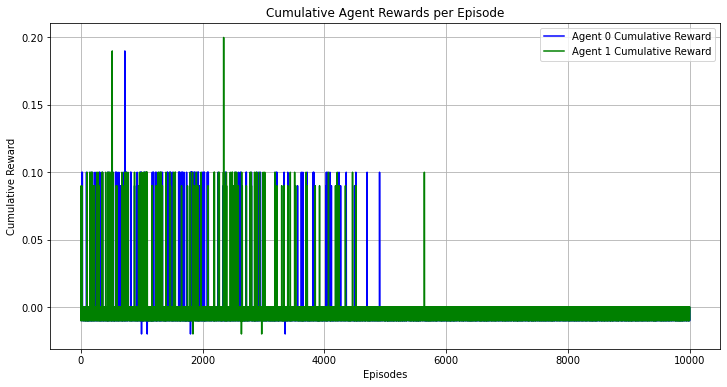

In [4]:
from collections import deque
import torch
import numpy as np
import matplotlib.pyplot as plt
import csv  # Import the csv module

# Assuming these are defined as in the notebook
# from maddpg_agent import MADDPG_Agent
# from utilities import OrnsteinUhlenbeckNoise, ExperienceMemory, plot_OU
# env, brain_name, config, device, EPISODES, ou_mu, ou_theta, ou_sigma, ou_scale, ou_decay, buffer_size, batch_size, PRINT_EVERY

score_deque = deque(maxlen=100)  # keep the maximum score over the agents in the past 100 episodes
score_list = [[], []]  # keep the score of each agent
max_score_list = []  # keep the higher score in the episode
agent_0_score_list = []  # Keep track of Agent 0's score
agent_1_score_list = []  # Keep track of Agent 1's score
agent_0_total_score = 0  # Keep track of Agent 0's total score
agent_1_total_score = 0  # Keep track of Agent 1's total score

# create the replay buffer
buffer = ExperienceMemory(buffer_size, batch_size)

# create the maddpg agents
# the index of the agents are 0 and 1
agents = [MADDPG_Agent(0, config), MADDPG_Agent(1, config)]

# create the noise process
noise_process = OrnsteinUhlenbeckNoise(4, ou_mu, ou_theta, ou_sigma)

# simulation of the noisen
# note that the sampling in this simulation is independent of the sampling during the maddpg training
print("Simulation of the noise Process:")
# plot_OU(EPISODES, ou_scale, ou_decay, 1, ou_mu, ou_theta, ou_sigma)  # Assuming plot_OU is defined
print("\n")

# Prepare to write to a CSV file
csv_file = open('agent_cumulative_rewards.csv', 'w', newline='')  # Open the file
csv_writer = csv.writer(csv_file)  # Create a CSV writer object
csv_writer.writerow(['Episode', 'Agent 0 Cumulative Reward', 'Agent 1 Cumulative Reward'])  # Write the header row

cumulative_agent_0_rewards = []
cumulative_agent_1_rewards = []

for ep in range(1, EPISODES + 1):
    # Reset total scores at the beginning of each episode
    agent_0_total_score = 0
    agent_1_total_score = 0
    
    # env information
    env_info = env.reset(train_mode=True)[brain_name]

    # initial state. env provides the states with the shape (2, 24), reshape it to (1, 48)
    states = env_info.vector_observations.reshape((1, 48))

    # scores for each agents
    scores = np.zeros(2)  # ndarray shape (2, )

    # time record_experiences
    t_record_experience = 0

    while True:
        t_record_experience += 1

        """
        Data collection
        """
        # split into the states into the parts observed by each agent (ndarray)
        states_0 = states[0, :24].reshape((1, 24))  # ndarray shape (1, 24)
        states_1 = states[0, 24:].reshape((1, 24))  # ndarray shape (1, 24)

        # convert the states into tensors
        states_0_t = torch.from_numpy(states_0).float().to(device)
        states_1_t = torch.from_numpy(states_1).float().to(device)

        # generate noise (ndarray)
        noise = ou_scale * noise_process.get_noise().reshape((1, 4))  # ndarray shape (1, 4)
        noise_avgabs = np.round(np.mean(np.abs(noise[0, :])), 3)  # see the average |noise| generated
        # split the noise into the parts for each agent
        noise_0 = noise[0, :2].reshape((1, 2))  # ndarray shape (1, 2)
        noise_1 = noise[0, 2:].reshape((1, 2))  # ndarray shape (1, 2)

        # decide actions by select_actionor_local, convert to ndarray
        actions_0 = agents[0].select_action(states_0_t, 'local', True, noise_0).detach().cpu().numpy()  # agent 0
        actions_1 = agents[1].select_action(states_1_t, 'local', True, noise_1).detach().cpu().numpy()  # agent 1
        actions = np.vstack((actions_0, actions_1))  # ndarray shape (2, 2)

        # use the actions to interselect_action with the environment
        env_info = env.step(actions)[brain_name]
        next_states = env_info.vector_observations.reshape(1, 48)  # next states, converted to ndarray shape (1, 48)
        rewards = np.array(env_info.rewards)  # ndarray shape (2, )
        dones = np.array(env_info.local_done)  # ndarray shape (2, )

        ## push into buffer
        # states.flatten()      # ndarray shape (48, )
        # actions.flatten()     # ndarray shape (4, )
        # rewards             # ndarray shape (2, )
        # next_states.flatten() # ndarray shape (48, )
        # dones               # ndarray shape (2, )
        buffer.store(states.flatten(), actions.flatten(), rewards, next_states.flatten(), dones)

        # update scores of each agent
        scores += rewards

        # advance to th next state
        states = next_states

        """
        Policy optimizeing
        """
        ## train the agents if we have enough replays in the buffer
        if len(buffer) >= batch_size:
            # agent 0
            agents[0].optimize(buffer.fetch_batch(), agents[1])  # train Agent 0
            # agent 1
            agents[1].optimize(buffer.fetch_batch(), agents[0])  # train Agent 1

        # end the episode if at least one agent is in the terminal state
        if np.any(dones):
            break

    # keep scores
    score_list[0].append(scores[0])
    score_list[1].append(scores[1])
    score_deque.append(scores.max())
    max_score_list.append(scores.max())
    agent_0_score_list.append(scores[0])  # Store Agent 0's score
    agent_1_score_list.append(scores[1])  # Store Agent 1's score
    agent_0_total_score += scores[0]
    agent_1_total_score += scores[1]
    # average score of the past 100 episodes
    AVG_100 = np.mean(score_deque)

    cumulative_agent_0_rewards.append(agent_0_total_score)
    cumulative_agent_1_rewards.append(agent_1_total_score)

    # print the information
    print(
        "\rEpisode {}\tScore: {:.2f}\tAvg: {:.2f}\t|ou|: {:.3f}\tAgent 0 Total: {:.2f}\tAgent 1 Total: {:.2f}".format(
            ep, scores.max(), AVG_100, noise_avgabs, agent_0_total_score, agent_1_total_score
        ),
        end="",
    )

    # Write the cumulative rewards to the CSV file
    csv_writer.writerow([ep, agent_0_total_score, agent_1_total_score])

    # print a new line for every PRINT_EVERY epiodes
    if ep % PRINT_EVERY == 0:
        print(
            "\rEpisode {}\tScore: {:.2f}\tAvg: {:.2f}\\t|ou|: {:.3f}\tAgent 0 Total: {:.5f}\tAgent 1 Total: {:.5f}".format(
                ep, scores.max(), AVG_100, noise_avgabs, agent_0_total_score, agent_1_total_score
            )
        )

    # the condition when the task is considered solved
    if AVG_100 > 0.5 and len(score_deque) >= 100:
        print("\nEnvironment is solved after {} episodes\n".format(ep - 100))
        break

    # decrease the scaling fselect_actionor of the noise
    ou_scale *= ou_decay

# Close the CSV file
csv_file.close()

## Save the weights
torch.save(agents[0].select_actionor_local.state_dict(), 'checkpoint_select_actionor_0.pth')
torch.save(agents[0].critic_local.state_dict(), 'checkpoint_critic_0.pth')
torch.save(agents[1].select_actionor_local.state_dict(), 'checkpoint_select_actionor_1.pth')
torch.save(agents[1].critic_local.state_dict(), 'checkpoint_critic_1.pth')

# Plot the cumulative score of each agent per episode
plt.figure(figsize=(12, 6))
plt.plot(range(1, EPISODES + 1), cumulative_agent_0_rewards, label='Agent 0 Cumulative Reward', color='blue')
plt.plot(range(1, EPISODES + 1), cumulative_agent_1_rewards, label='Agent 1 Cumulative Reward', color='green')
plt.xlabel("Episodes")
plt.ylabel("Cumulative Reward")
plt.title("Cumulative Agent Rewards per Episode")
plt.legend()
plt.grid(True)
plt.show()

## Box 4: Loading trained weights

Run the box below to use the pre-trained weights to watch the agents hit some volleys

In [5]:
## Test the saved weights

# create the maddpg agents
agents = [MADDPG_Agent(0, config), MADDPG_Agent(1, config)]

# load the pre-trained weights from the working directory (change the file name if needed)

agents[0].select_actionor_local.load_state_dict(torch.load('checkpoint_select_actionor_0.pth'))      # Agent 0: select_actionor
agents[0].critic_local.load_state_dict(torch.load('checkpoint_critic_0.pth'))    # Agent 0: critic

agents[1].select_actionor_local.load_state_dict(torch.load('checkpoint_select_actionor_1.pth'))      # Agent 1: select_actionor
agents[1].critic_local.load_state_dict(torch.load('checkpoint_critic_1.pth'))    # Agent 1: critic


# initialize the environment
env_info = env.reset(train_mode = False)[brain_name]

# initial state. env provides the states with the shape (2, 24), reshape it to (1, 48)
states = env_info.vector_observations.reshape((1, 48))

# scores of the agents
scores = [0, 0]

while True:
    # split into the states into the parts observed by each agent (ndarray)
    states_0 = states[0, :24] 
    states_1 = states[0, 24:]

    # convert the states into tensors
    states_0_t = torch.from_numpy(states_0).float().to(device)
    states_1_t = torch.from_numpy(states_1).float().to(device)


    # decide actions by select_actionor_local, convert to ndarray
    actions_0 = agents[0].select_action(states_0_t, 'local', False).detach().cpu().numpy()   # Agent 0
    actions_1 = agents[1].select_action(states_1_t, 'local', False).detach().cpu().numpy()   # Agent 1
    actions = np.vstack((actions_0, actions_1)) # shape (2, 2)

    # use the actions to interselect_action with the environment
    env_info = env.record_experience(actions)[brain_name]                     # env info
    next_states = env_info.vector_observations.reshape((1, 48))  # next states, converted to ndarray shape (1, 48)
    rewards = env_info.rewards                                   # rewards, list of len = 2
    dones = env_info.local_done                                  # dones, list of len = 2

    # update scores of each agent
    scores[0] += rewards[0]
    scores[1] += rewards[1]

    # advance to th next state
    states = next_states
    
    # break if entering a terminal state
    if np.any(dones):
        break
        
        
print('Total score (max over the players) this episode: {:.2f}'.format(max(scores)))


# # create the maddpg agents
# agents = [MADDPG_Agent(0, config), MADDPG_Agent(1, config)]

# # load the pre-trained weights from the working directory (change the file name if needed)
# agents[0].select_actionor_local.load_state_dict(torch.load('checkpoint_select_actionor_0.pth'))    # Agent 0: actor
# agents[0].critic_local.load_state_dict(torch.load('checkpoint_critic_0.pth'))    # Agent 0: critic
# agents[1].select_actionor_local.load_state_dict(torch.load('checkpoint_select_actionor_1.pth'))    # Agent 1: actor
# agents[1].critic_local.load_state_dict(torch.load('checkpoint_critic_1.pth'))    # Agent 1: critic

# # initialize the environment
# env_info = env.reset(train_mode=False)[brain_name]

# # initial state. env provides the states with the shape (2, 24), reshape it to (1, 48)
# states = env_info.vector_observations.reshape((1, 48))

# # scores of the agents
# scores = [0, 0]
# episode_scores = []  # To store scores for each episode

# while True:
#     # split into the states into the parts observed by each agent (ndarray)
#     states_0 = states[0, :24]
#     states_1 = states[0, 24:]

#     # convert the states into tensors
#     states_0_t = torch.from_numpy(states_0).float().to(device)
#     states_1_t = torch.from_numpy(states_1).float().to(device)

#     # decide actions by actor_local, convert to ndarray
#     actions_0 = agents[0].select_action(states_0_t, 'local', False).detach().cpu().numpy()    # Agent 0
#     actions_1 = agents[1].select_action(states_1_t, 'local', False).detach().cpu().numpy()    # Agent 1
#     actions = np.vstack((actions_0, actions_1)) # shape (2, 2)

#     # use the actions to interact with the environment
#     env_info = env.step(actions)[brain_name]
#     next_states = env_info.vector_observations.reshape((1, 48)) # next states, converted to ndarray shape (1, 48)
#     rewards = env_info.rewards         # rewards, list of len = 2
#     dones = env_info.local_done         # dones, list of len = 2

#     # update scores of each agent
#     scores[0] += rewards[0]
#     scores[1] += rewards[1]

#     # advance to the next state
#     states = next_states
    
#     # break if entering a terminal state
#     if np.any(dones):
#         episode_scores.append(scores)  # Store the scores of the episode
#         print('Total score this episode: {:.2f}, Agent 0: {:.2f}, Agent 1: {:.2f}'.format(max(scores), scores[0], scores[1]))
#         if scores[0] > scores[1]:
#             print("Agent 0 won the episode")
#         elif scores[1] > scores[0]:
#             print("Agent 1 won the episode")
#         else:
#             print("It was a tie")
#         break


ValueError: expected 2D or 3D input (got 1D input)

In [ ]:
# import pandas as pd
# import torch
# import numpy as np
# import matplotlib.pyplot as plt

# # Load the environment and agents (assuming this part is already defined as in your provided code)
# env_info = env.reset(train_mode=False)[brain_name]
# agents = [MADDPG_Agent(0, config), MADDPG_Agent(1, config)]

# # Load the pre-trained weights
# agents[0].select_actionor_local.load_state_dict(torch.load('checkpoint_select_actionor_0.pth'))
# agents[0].critic_local.load_state_dict(torch.load('checkpoint_critic_0.pth'))
# agents[1].select_actionor_local.load_state_dict(torch.load('checkpoint_select_actionor_1.pth'))
# agents[1].critic_local.load_state_dict(torch.load('checkpoint_critic_1.pth'))

# states = env_info.vector_observations.reshape((1, 48))
# scores = [0, 0]
# episode_scores = []
# episode_number = 0  # Keep track of the episode number

# try:
#     while True:
#         states_0 = states[0, :24]
#         states_1 = states[0, 24:]
#         states_0_t = torch.from_numpy(states_0).float().to(device)
#         states_1_t = torch.from_numpy(states_1).float().to(device)
#         actions_0 = agents[0].select_action(states_0_t, 'local', False).detach().cpu().numpy()
#         actions_1 = agents[1].select_action(states_1_t, 'local', False).detach().cpu().numpy()
#         actions = np.vstack((actions_0, actions_1))
#         env_info = env.step(actions)[brain_name]
#         next_states = env_info.vector_observations.reshape((1, 48))
#         rewards = env_info.rewards
#         dones = env_info.local_done
#         scores[0] += rewards[0]
#         scores[1] += rewards[1]
#         states = next_states
#         if np.any(dones):
#             episode_number += 1  # Increment episode number
#             episode_scores.append([episode_number, scores[0], scores[1]])  # Store episode number with scores
#             print(f'Episode {episode_number} - Total score: {max(scores):.2f}, Agent 0: {scores[0]:.2f}, Agent 1: {scores[1]:.2f}')
#             if scores[0] > scores[1]:
#                 print("Agent 0 won the episode")
#             elif scores[1] > scores[0]:
#                 print("Agent 1 won the episode")
#             else:
#                 print("It was a tie")
#             scores = [0, 0] #reset the scores.
#             env_info = env.reset(train_mode=False)[brain_name] #reset the environment.
#             states = env_info.vector_observations.reshape((1, 48)) #reset the states

#             if episode_number >= 100: # changed to 100
#                 break
# finally:  # This block will execute whether the loop finishes or an error occurs
#     # Create the DataFrame
#     df = pd.DataFrame(episode_scores, columns=['Episode No', 'Score of Agent 0', 'Score of Agent 1'])

#     # Save to CSV
#     csv_file_path = '\Users\indir\agent_scores.csv'
#     df.to_csv(csv_file_path, index=False)
#     print(f"Scores saved to {csv_file_path}")

#     # Create the plot
#     plt.figure(figsize=(10, 6))
#     plt.plot(df['Episode No'], df['Score of Agent 0'], label='Agent 0')
#     plt.plot(df['Episode No'], df['Score of Agent 1'], label='Agent 1')
#     plt.xlabel('Episode Number')
#     plt.ylabel('Score')
#     plt.title('Episodic Rewards')
#     plt.legend()
#     plt.grid(True)
#     plt.show()  # Display the plot

#     env.close()  # Close the environment


Lastly, please run the command below to close the environment

In [ ]:
env.close()

## References

Papers:

1. R. Lowe et al., 2017. *Multi-Agent Actor-Critic for Mixed Cooperative-Competitive Environments*

    https://arxiv.org/abs/1706.02275 (MADDPG)


2. T. P. Lillicrap et al., 2016. *Continuous control with deep reinforcement learning*

    https://arxiv.org/abs/1509.02971 (DDPG)


This code was inspired by:

1. Udacity's GitHub repository **ddpg-pendulum** (ddpg_agent.py)

    https://github.com/udacity/deep-reinforcement-learning/tree/master/ddpg-pendulum


2. Udacity's jupyter notebook template of **Project: Collaboration and Competition**


3. Udacity's drlnd MADDPG-Lab